# TNG Group Catalog : TNG300 vs. TNG50

## Import Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

In [2]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

## Define SparkSession and sparkContext

In [3]:
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "150") \
    .getOrCreate()


sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [5]:
sc.getConf().getAll()[:10]

[('spark.driver.memory', '32g'),
 ('spark.driver.appUIAddress', 'http://spark00:4040'),
 ('spark.driver.maxResultSize', '32g'),
 ('spark.app.startTime', '1749018026226'),
 ('spark.master', 'yarn'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir',
  'file:/home/shong/work/illustris/notebook/spark-warehouse'),
 ('spark.app.id', 'application_1742867806927_0004'),
 ('spark.executor.instances', '150'),
 ('spark.submit.deployMode', 'client')]

## Read All Subhalo Parquet Files

- About IllustrisTNG, https://www.illustris-project.org/data/docs/specifications/
- About TNG300, https://www.tng-project.org/data/downloads/TNG300-1/

In [6]:
data50path = "hdfs://spark00:54310/common/data/illustris/tng50/snapshot99/groupcat/"
data100path = "hdfs://spark00:54310/common/data/illustris/tng100/snapshot99/groupcat/"
data300path = "hdfs://spark00:54310/common/data/illustris/tng300/snapshot99/groupcat/"

In [7]:
outpath = "hdfs://spark00:54310/common/data/illustris/tng50/snapshot99/reduced/"

In [8]:
%%time
# Read all parquets in the directory
sdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(data50path)
mdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(data100path)
ldf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(data300path)

CPU times: user 4.03 ms, sys: 41 µs, total: 4.07 ms
Wall time: 6.21 s


In [9]:
sdf.printSchema()

root
 |-- SubhaloBHMass: float (nullable = true)
 |-- SubhaloBHMdot: float (nullable = true)
 |-- SubhaloBfldDisk: float (nullable = true)
 |-- SubhaloBfldHalo: float (nullable = true)
 |-- SubhaloCM: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- SubhaloFlag: boolean (nullable = true)
 |-- SubhaloGasMetalFractions: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- SubhaloGasMetalFractionsHalfRad: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- SubhaloGasMetalFractionsMaxRad: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- SubhaloGasMetalFractionsSfr: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- SubhaloGasMetalFractionsSfrWeighted: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- SubhaloGasMetallicity: float (nullable = true)
 |-- SubhaloGasMetallicityHalfRad: float (nullable = true)
 |-- SubhaloGasMetallicityMaxRad: fl

## Mass Function

#### Plot the histogram of `SubhaloMass`

In [15]:
%%time
# Step 1: Convert 'SubhaloMass' to Pandas
smass = sdf.select("SubhaloMass").toPandas()["SubhaloMass"]
mmass = mdf.select("SubhaloMass").toPandas()["SubhaloMass"]
lmass = ldf.select("SubhaloMass").toPandas()["SubhaloMass"]

CPU times: user 137 ms, sys: 129 ms, total: 265 ms
Wall time: 1min 41s


In [57]:
smass.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5688113 entries, 0 to 5688112
Series name: SubhaloMass
Non-Null Count    Dtype  
--------------    -----  
5688113 non-null  float32
dtypes: float32(1)
memory usage: 21.7 MB


In [16]:
# Step 2: Define Log-Spaced Bins
num_bins = 50  # Adjust as needed
#log_bins = np.logspace(np.log10(subhalo_mass.min()), np.log10(subhalo_mass.max()), num_bins)
log_bins = np.logspace(np.log10(0.0001), np.log10(1e5), num_bins)

In [20]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

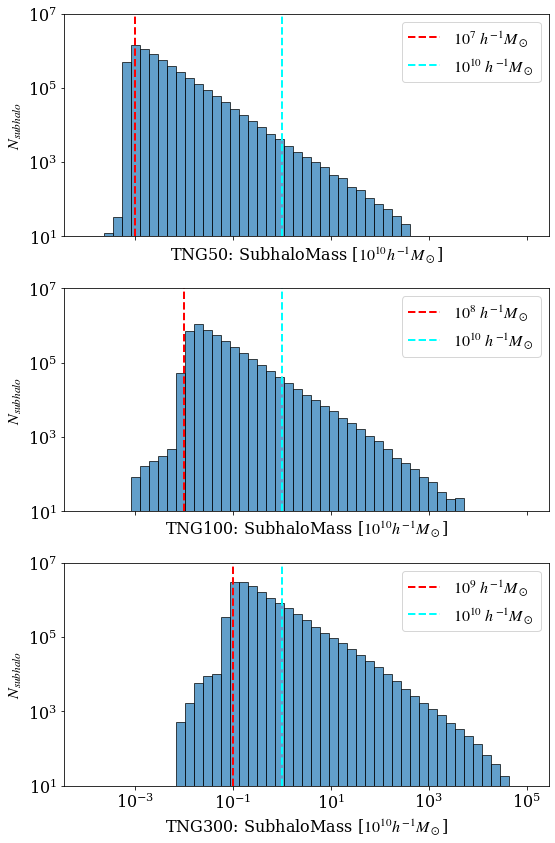

In [21]:
# Create a 3-row, 1-column subplot layout
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True, sharey=True)

# Plot for smass (TNG50)
axes[0].hist(smass, bins=log_bins, edgecolor='black', alpha=0.7, log=True)
axes[0].set_ylabel(r'$N_{subhalo}$')
axes[0].set_xscale("log")
axes[0].set_ylim(1e1, 1e7)
axes[0].set_xlabel(r'TNG50: SubhaloMass [$10^{10} h^{-1} M_\odot$]')
axes[0].axvline(x=10**-3, color='red', linestyle='--', linewidth=2, label=r'$10^{7}~ h^{-1} M_\odot$')
axes[0].axvline(x=10**0, color='cyan', linestyle='--', linewidth=2, label=r'$10^{10}~ h^{-1} M_\odot$')
axes[0].legend()

# Plot for mmass (TNG100)
axes[1].hist(mmass, bins=log_bins, edgecolor='black', alpha=0.7, log=True)
axes[1].set_ylabel(r'$N_{subhalo}$')
axes[1].set_xscale("log")
axes[1].set_ylim(1e1, 1e7)
axes[1].set_xlabel(r'TNG100: SubhaloMass [$10^{10} h^{-1} M_\odot$]')
axes[1].axvline(x=10**-2, color='red', linestyle='--', linewidth=2, label=r'$10^{8}~ h^{-1} M_\odot$')
axes[1].axvline(x=10**0, color='cyan', linestyle='--', linewidth=2, label=r'$10^{10}~ h^{-1} M_\odot$')
axes[1].legend()

# Plot for lmass (TNG300)
axes[2].hist(lmass, bins=log_bins, edgecolor='black', alpha=0.7, log=True)
axes[2].set_ylabel(r'$N_{subhalo}$')
axes[2].set_xscale("log")
axes[2].set_ylim(1e1, 1e7)
axes[2].set_xlabel(r'TNG300: SubhaloMass [$10^{10} h^{-1} M_\odot$]')
axes[2].axvline(x=10**-1, color='red', linestyle='--', linewidth=2, label=r'$10^{9}~ h^{-1} M_\odot$')
axes[2].axvline(x=10**0, color='cyan', linestyle='--', linewidth=2, label=r'$10^{10}~ h^{-1} M_\odot$')
axes[2].legend()

# Tidy layout
plt.tight_layout()

# Save the figure
plt.savefig("tng-all-massfunc-3x1.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.show()

- Simulation Completeness Limit near 
$10^{7} M_\odot$ vs. $10^{9} M_\odot$

### Explode SubhaloMassType

In [22]:
# Define the band names
mass_names = ["m_gas", "m_dm", "dummy", "tr_dummy", "m_star", "m_bh"]

In [23]:
# Select and create new columns
for idx, mtype in enumerate(mass_names):
    sdf = sdf.withColumn(mtype, F.col('SubhaloMassType').getItem(idx))

In [24]:
# Select and create new columns
for idx, mtype in enumerate(mass_names):
    mdf = mdf.withColumn(mtype, F.col('SubhaloMassType').getItem(idx))

In [25]:
# Select and create new columns
for idx, mtype in enumerate(mass_names):
    ldf = ldf.withColumn(mtype, F.col('SubhaloMassType').getItem(idx))

In [26]:
%%time
sdf.select(['SubhaloMass',"m_dm", "m_gas", "m_star", "m_bh"]).show(5,truncate=False)

+-----------+-----------+-----+------------+----+
|SubhaloMass|m_dm       |m_gas|m_star      |m_bh|
+-----------+-----------+-----+------------+----+
|0.025727784|0.025296362|0.0  |4.3142235E-4|0.0 |
|0.02883109 |0.02883109 |0.0  |0.0         |0.0 |
|0.028777229|0.028769618|0.0  |7.611349E-6 |0.0 |
|0.02883109 |0.02883109 |0.0  |0.0         |0.0 |
|0.028800353|0.028800353|0.0  |0.0         |0.0 |
+-----------+-----------+-----+------------+----+
only showing top 5 rows

CPU times: user 1.25 ms, sys: 481 µs, total: 1.73 ms
Wall time: 326 ms


### Explode SubhaloMassInHalfRadType

In [60]:
# Define the band names
half_mass_names = ["m_gas_rhstar", "m_dm_rhstar", "dummy_rhstar", "tr_dummy_rhstar", \
              "m_star_rhstar", "m_bh_rhstar"]

In [61]:
# Select and create new columns
for idx, mtype in enumerate(half_mass_names):
    sdf = sdf.withColumn(mtype, F.col('SubhaloMassInHalfRadType').getItem(idx))

In [62]:
# Select and create new columns
for idx, mtype in enumerate(half_mass_names):
    mdf = mdf.withColumn(mtype, F.col('SubhaloMassInHalfRadType').getItem(idx))

In [63]:
# Select and create new columns
for idx, mtype in enumerate(half_mass_names):
    ldf = ldf.withColumn(mtype, F.col('SubhaloMassInHalfRadType').getItem(idx))

In [66]:
%%time
mdf.select(['SubhaloMass',"m_dm", "m_gas", "m_star","m_star_rhstar", "m_bh"]).show(5,truncate=False)

+-----------+---------+---------+---------+-------------+-----------+
|SubhaloMass|m_dm     |m_gas    |m_star   |m_star_rhstar|m_bh       |
+-----------+---------+---------+---------+-------------+-----------+
|27477.936  |23325.62 |3900.5981|251.01631|125.50809    |0.70181096 |
|3666.6228  |3184.0862|444.55853|37.85255 |18.926231    |0.12556633 |
|773.4555   |718.18396|12.611633|42.482437|21.2412      |0.17748705 |
|339.1331   |310.50958|16.9682  |11.620896|5.8104267    |0.034418035|
|325.3667   |306.84265|9.439245 |9.032478 |4.5162363    |0.05234062 |
+-----------+---------+---------+---------+-------------+-----------+
only showing top 5 rows

CPU times: user 1.86 ms, sys: 0 ns, total: 1.86 ms
Wall time: 117 ms


In [67]:
%%time
mdf.select(['SubhaloMass',"m_dm", "m_gas", "m_star", "m_bh"]).show(5,truncate=False)

+-----------+---------+---------+---------+-----------+
|SubhaloMass|m_dm     |m_gas    |m_star   |m_bh       |
+-----------+---------+---------+---------+-----------+
|27477.936  |23325.62 |3900.5981|251.01631|0.70181096 |
|3666.6228  |3184.0862|444.55853|37.85255 |0.12556633 |
|773.4555   |718.18396|12.611633|42.482437|0.17748705 |
|339.1331   |310.50958|16.9682  |11.620896|0.034418035|
|325.3667   |306.84265|9.439245 |9.032478 |0.05234062 |
+-----------+---------+---------+---------+-----------+
only showing top 5 rows

CPU times: user 2.13 ms, sys: 0 ns, total: 2.13 ms
Wall time: 136 ms


In [28]:
%%time
ldf.select(['SubhaloMass',"m_dm", "m_gas", "m_star", "m_bh"]).show(5,truncate=False)

+-----------+----------+----------+-----------+------------+
|SubhaloMass|m_dm      |m_gas     |m_star     |m_bh        |
+-----------+----------+----------+-----------+------------+
|0.17527081 |0.17527081|0.0       |0.0        |0.0         |
|8.560058   |7.735816  |0.80635756|0.017060202|8.238204E-4 |
|0.1872211  |0.1872211 |0.0       |0.0        |0.0         |
|9.599063   |8.974662  |0.6060134 |0.017164726|0.0012226128|
|0.11950283 |0.11950283|0.0       |0.0        |0.0         |
+-----------+----------+----------+-----------+------------+
only showing top 5 rows

CPU times: user 0 ns, sys: 2.69 ms, total: 2.69 ms
Wall time: 234 ms


In [35]:
%%time
# Step 1: Convert 'SubhaloMass' to Pandas
smdm = sdf.select("m_dm").toPandas()["m_dm"]
mmdm = mdf.select("m_dm").toPandas()["m_dm"]
lmdm = ldf.select("m_dm").toPandas()["m_dm"]

CPU times: user 143 ms, sys: 86.4 ms, total: 230 ms
Wall time: 29.3 s


In [36]:
%%time
smstar = sdf.select("m_star").toPandas()["m_star"]
mmstar = mdf.select("m_star").toPandas()["m_star"]
lmstar = ldf.select("m_star").toPandas()["m_star"]

CPU times: user 127 ms, sys: 101 ms, total: 228 ms
Wall time: 21.7 s


In [37]:
smdm.head()

0    0.025296
1    0.028831
2    0.028770
3    0.028831
4    0.028800
Name: m_dm, dtype: float32

In [38]:
smstar.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5688113 entries, 0 to 5688112
Series name: m_star
Non-Null Count    Dtype  
--------------    -----  
5688113 non-null  float32
dtypes: float32(1)
memory usage: 21.7 MB


In [39]:
smdm.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5688113 entries, 0 to 5688112
Series name: m_dm
Non-Null Count    Dtype  
--------------    -----  
5688113 non-null  float32
dtypes: float32(1)
memory usage: 21.7 MB


In [40]:
# Step 2: Define Log-Spaced Bins
num_bins = 50  # Adjust as needed
#log_bins = np.logspace(np.log10(subhalo_mass.min()), np.log10(subhalo_mass.max()), num_bins)
log_bins = np.logspace(np.log10(0.0001), np.log10(1e5), num_bins)

In [44]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

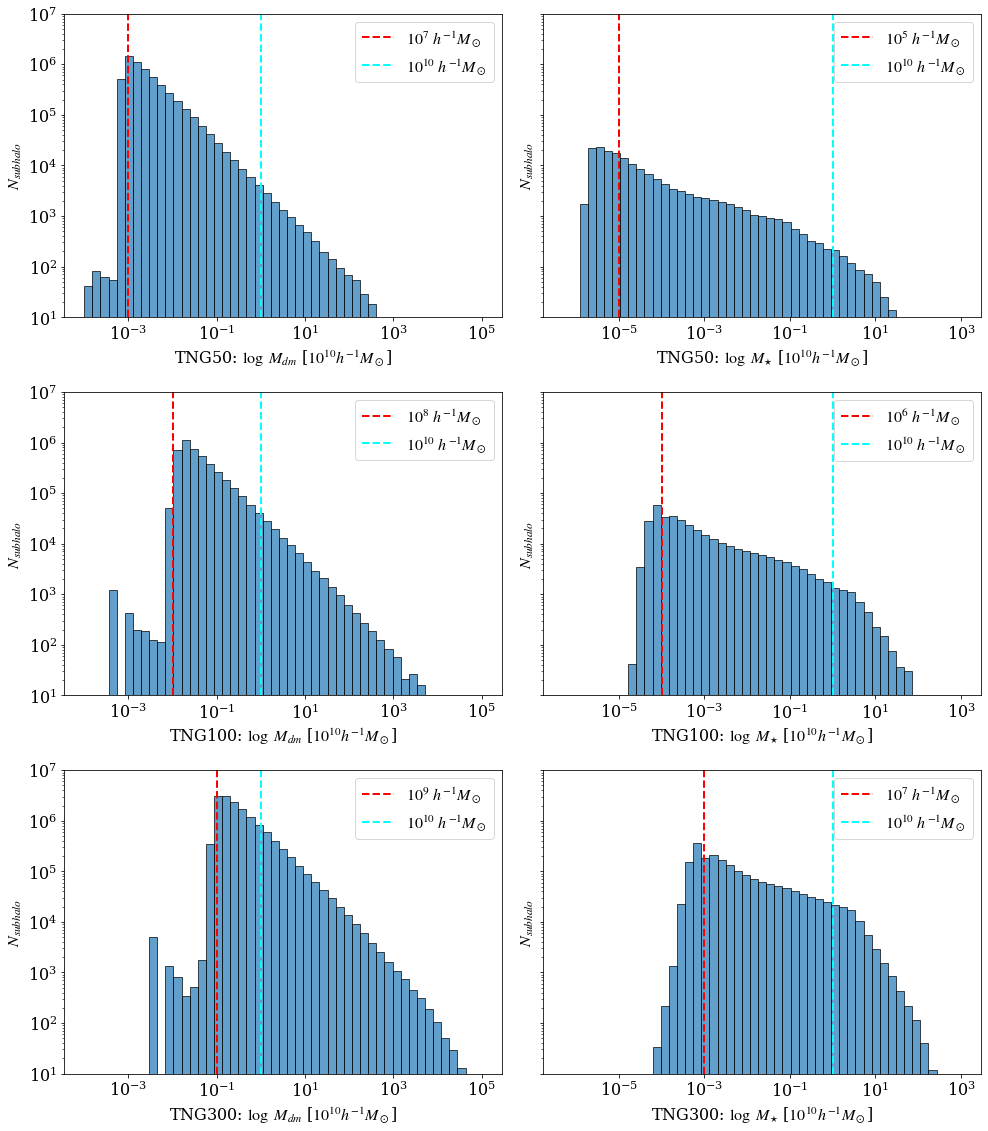

In [47]:
# Create a 3-row, 2-column subplot layout
fig, axes = plt.subplots(3, 2, figsize=(14, 16), sharey=True)

# Define log-spaced bins
num_bins = 50
log_bins_dm = np.logspace(np.log10(0.0001), np.log10(1e5), num_bins)
log_bins_star = np.logspace(np.log10(5e-7), np.log10(1e3), num_bins)

# --- Row 0: TNG50 ---
# smdm
axes[0, 0].hist(smdm, bins=log_bins_dm, edgecolor='black', alpha=0.7, log=True)
axes[0, 0].set_ylim(1e1, 1e7)
axes[0, 0].set_ylabel(r'$N_{subhalo}$')
axes[0, 0].set_xlabel(r'TNG50: $\log~M_{dm}$ [$10^{10} h^{-1} M_\odot$]')
axes[0, 0].set_xscale("log")
axes[0, 0].axvline(10**-3, color='red', linestyle='--', linewidth=2, label=r'$10^7~ h^{-1} M_\odot$')
axes[0, 0].axvline(10**0, color='cyan', linestyle='--', linewidth=2, label=r'$10^{10}~ h^{-1} M_\odot$')
axes[0, 0].legend()

# smstar
axes[0, 1].hist(smstar, bins=log_bins_star, edgecolor='black', alpha=0.7, log=True)
axes[0, 1].set_ylim(1e1, 1e7)
axes[0, 1].set_ylabel(r'$N_{subhalo}$')
axes[0, 1].set_xlabel(r'TNG50: $\log~M_{\star}$ [$10^{10} h^{-1} M_\odot$]')
axes[0, 1].set_xscale("log")
axes[0, 1].axvline(10**-5, color='red', linestyle='--', linewidth=2, label=r'$10^5~ h^{-1} M_\odot$')
axes[0, 1].axvline(10**0, color='cyan', linestyle='--', linewidth=2, label=r'$10^{10}~ h^{-1} M_\odot$')
axes[0, 1].legend()

# --- Row 1: TNG100 ---
# mmdm
axes[1, 0].hist(mmdm, bins=log_bins_dm, edgecolor='black', alpha=0.7, log=True)
axes[1, 0].set_ylim(1e1, 1e7)
axes[1, 0].set_ylabel(r'$N_{subhalo}$')
axes[1, 0].set_xlabel(r'TNG100: $\log~M_{dm}$ [$10^{10} h^{-1} M_\odot$]')
axes[1, 0].set_xscale("log")
axes[1, 0].axvline(10**-2, color='red', linestyle='--', linewidth=2, label=r'$10^8~ h^{-1} M_\odot$')
axes[1, 0].axvline(10**0, color='cyan', linestyle='--', linewidth=2, label=r'$10^{10}~ h^{-1} M_\odot$')
axes[1, 0].legend()

# mmstar
axes[1, 1].hist(mmstar, bins=log_bins_star, edgecolor='black', alpha=0.7, log=True)
axes[1, 1].set_ylim(1e1, 1e7)
axes[1, 1].set_ylabel(r'$N_{subhalo}$')
axes[1, 1].set_xlabel(r'TNG100: $\log~M_{\star}$ [$10^{10} h^{-1} M_\odot$]')
axes[1, 1].set_xscale("log")
axes[1, 1].axvline(10**-4, color='red', linestyle='--', linewidth=2, label=r'$10^6~ h^{-1} M_\odot$')
axes[1, 1].axvline(10**0, color='cyan', linestyle='--', linewidth=2, label=r'$10^{10}~ h^{-1} M_\odot$')
axes[1, 1].legend()

# --- Row 2: TNG300 ---
# lmdm
axes[2, 0].hist(lmdm, bins=log_bins_dm, edgecolor='black', alpha=0.7, log=True)
axes[2, 0].set_ylim(1e1, 1e7)
axes[2, 0].set_ylabel(r'$N_{subhalo}$')
axes[2, 0].set_xlabel(r'TNG300: $\log~M_{dm}$ [$10^{10} h^{-1} M_\odot$]')
axes[2, 0].set_xscale("log")
axes[2, 0].axvline(10**-1, color='red', linestyle='--', linewidth=2, label=r'$10^9~ h^{-1} M_\odot$')
axes[2, 0].axvline(10**0, color='cyan', linestyle='--', linewidth=2, label=r'$10^{10}~ h^{-1} M_\odot$')
axes[2, 0].legend()

# lmstar
axes[2, 1].hist(lmstar, bins=log_bins_star, edgecolor='black', alpha=0.7, log=True)
axes[2, 1].set_ylim(1e1, 1e7)
axes[2, 1].set_ylabel(r'$N_{subhalo}$')
axes[2, 1].set_xlabel(r'TNG300: $\log~M_{\star}$ [$10^{10} h^{-1} M_\odot$]')
axes[2, 1].set_xscale("log")
axes[2, 1].axvline(10**-3, color='red', linestyle='--', linewidth=2, label=r'$10^7~ h^{-1} M_\odot$')
axes[2, 1].axvline(10**0, color='cyan', linestyle='--', linewidth=2, label=r'$10^{10}~ h^{-1} M_\odot$')
axes[2, 1].legend()

# Layout and save
plt.tight_layout()



plt.savefig("tng-all-dm-star-massfunc.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("tng-both-dm-star-massfunc.png", format="png", bbox_inches="tight")
plt.show()

#### Assigning `isubhalotype`

In [29]:
# Compute `isubhalotype`
sdf = sdf.withColumn(
    "isubhalotype",
    (F.when(F.col("m_dm") > 0, 1).otherwise(0) +
     F.when(F.col("m_gas") > 0, 4).otherwise(0) +
     F.when(F.col("m_star") > 0, 8).otherwise(0) +
     F.when(F.col("m_bh") > 0, 16).otherwise(0))
)

In [30]:
# Compute `isubhalotype`
mdf = mdf.withColumn(
    "isubhalotype",
    (F.when(F.col("m_dm") > 0, 1).otherwise(0) +
     F.when(F.col("m_gas") > 0, 4).otherwise(0) +
     F.when(F.col("m_star") > 0, 8).otherwise(0) +
     F.when(F.col("m_bh") > 0, 16).otherwise(0))
)

In [31]:
# Compute `isubhalotype`
ldf = ldf.withColumn(
    "isubhalotype",
    (F.when(F.col("m_dm") > 0, 1).otherwise(0) +
     F.when(F.col("m_gas") > 0, 4).otherwise(0) +
     F.when(F.col("m_star") > 0, 8).otherwise(0) +
     F.when(F.col("m_bh") > 0, 16).otherwise(0))
)

In [32]:
%%time
sdf.select(['SubhaloMass',"m_dm", "m_gas", "m_star", "m_bh",'isubhalotype']) \
.show(5,truncate=False)

+-----------+-----------+-----+------------+----+------------+
|SubhaloMass|m_dm       |m_gas|m_star      |m_bh|isubhalotype|
+-----------+-----------+-----+------------+----+------------+
|0.025727784|0.025296362|0.0  |4.3142235E-4|0.0 |9           |
|0.02883109 |0.02883109 |0.0  |0.0         |0.0 |1           |
|0.028777229|0.028769618|0.0  |7.611349E-6 |0.0 |9           |
|0.02883109 |0.02883109 |0.0  |0.0         |0.0 |1           |
|0.028800353|0.028800353|0.0  |0.0         |0.0 |1           |
+-----------+-----------+-----+------------+----+------------+
only showing top 5 rows

CPU times: user 1.3 ms, sys: 500 µs, total: 1.8 ms
Wall time: 238 ms


In [33]:
%%time
mdf.select(['SubhaloMass',"m_dm", "m_gas", "m_star", "m_bh",'isubhalotype']) \
.show(5,truncate=False)

+-----------+---------+---------+---------+-----------+------------+
|SubhaloMass|m_dm     |m_gas    |m_star   |m_bh       |isubhalotype|
+-----------+---------+---------+---------+-----------+------------+
|27477.936  |23325.62 |3900.5981|251.01631|0.70181096 |29          |
|3666.6228  |3184.0862|444.55853|37.85255 |0.12556633 |29          |
|773.4555   |718.18396|12.611633|42.482437|0.17748705 |29          |
|339.1331   |310.50958|16.9682  |11.620896|0.034418035|29          |
|325.3667   |306.84265|9.439245 |9.032478 |0.05234062 |29          |
+-----------+---------+---------+---------+-----------+------------+
only showing top 5 rows

CPU times: user 1.89 ms, sys: 0 ns, total: 1.89 ms
Wall time: 458 ms


In [36]:
# Compute the group count for each `isubhalotype`
hist_subtype_sdf = sdf.groupBy("isubhalotype").agg(F.count("*").alias("count"))
hist_subtype_sdf = hist_subtype_sdf.orderBy(F.col("count").desc())

In [37]:
%%time
hist_subtype_spdf = hist_subtype_sdf.toPandas()

CPU times: user 8.07 ms, sys: 278 µs, total: 8.35 ms
Wall time: 7.92 s


In [38]:
# Compute the group count for each `isubhalotype`
hist_subtype_ldf = ldf.groupBy("isubhalotype").agg(F.count("*").alias("count"))
hist_subtype_ldf = hist_subtype_ldf.orderBy(F.col("count").desc())

In [39]:
%%time
hist_subtype_lpdf = hist_subtype_ldf.toPandas()

CPU times: user 4.66 ms, sys: 254 µs, total: 4.91 ms
Wall time: 10.3 s


In [40]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 14})
plt.rcParams['mathtext.fontset'] = 'stix'

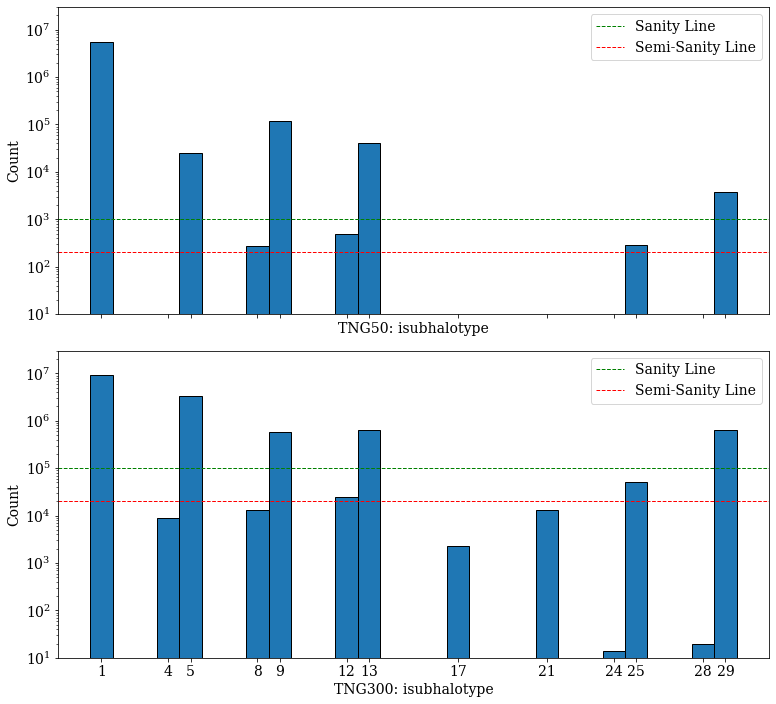

In [41]:
# Create figure with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)

# Top panel: hist_subtype_spdf (was bottom before)
axes[0].set_yscale("log")
axes[0].bar(hist_subtype_spdf["isubhalotype"], hist_subtype_spdf["count"], width=1.0, edgecolor="black")
axes[0].axhline(y=1e3, color='green', linestyle='--', linewidth=1, label='Sanity Line')
axes[0].axhline(y=2e2, color='red', linestyle='--', linewidth=1, label='Semi-Sanity Line')
axes[0].set_xlabel("TNG50: isubhalotype")
axes[0].set_ylabel("Count")
axes[0].legend(loc=0)
axes[0].set_ylim(1e1, 3e7)
axes[0].set_xticks(hist_subtype_spdf["isubhalotype"])

# Bottom panel: hist_subtype_lpdf (was top before)
axes[1].set_yscale("log")
axes[1].bar(hist_subtype_lpdf["isubhalotype"], hist_subtype_lpdf["count"], width=1.0, edgecolor="black")
axes[1].axhline(y=1e5, color='green', linestyle='--', linewidth=1, label='Sanity Line') 
axes[1].axhline(y=2e4, color='red', linestyle='--', linewidth=1, label='Semi-Sanity Line')
axes[1].set_xlabel("TNG300: isubhalotype")
axes[1].set_ylabel("Count")
axes[1].legend(loc=0)
axes[1].set_ylim(1e1, 3e7)
axes[1].set_xticks(hist_subtype_lpdf["isubhalotype"])

# Layout and save
plt.tight_layout()
plt.savefig("tng-both-isubhalotype-hist.pdf", format="pdf", bbox_inches="tight")
plt.savefig("tng-both-isubhalotype-hist.png", format="png", bbox_inches="tight")
plt.show()

- **1: DM only**
- 4: Gas only (what?!?)
- **5: DM + Gas**
- 8: Star only (what?!?)
- *9:* **DM + Star (no gas?!? strong feedback?)**
- *12: Gas + Star (no dm?!?, tidally stripped subhalo?)*
- **13: DM + Gas + Star (good)** 
- 17: DM + BH (what?!?)
- 21: DM + Gas + BH (no star?!? what?!?) 
- 24: Star + BH (what?!?) 
- *25:* **DM + Star + BH (no gas?!? even stronger feedback?)**
- 28: Gas + Star + BH 
- **29: DM + Gas + Star + BH**

In [44]:
hist_subtype_spdf

isubhalotype    count
0             1  5499951
1             9   117358
2            13    41090
3             5    24889
4            29     3765
5            12      500
6            25      286
7             8      268
8             4        6

In [45]:
hist_subtype_lpdf

isubhalotype    count
0              1  9245720
1              5  3267700
2             13   641501
3             29   632154
4              9   586390
5             25    49998
6             12    24952
7             21    13356
8              8    12899
9              4     8749
10            17     2256
11            28       20
12            24       14

### SFR vs. Stellar Mass

In [34]:
%%time
# Convert to Pandas and remove rows with zero or negative values
spdf = sdf.select(['m_star', 'SubhaloSFR']).toPandas()
spdf = spdf[(spdf["m_star"] > 0) & (spdf["SubhaloSFR"] > 0)]  # Remove zeros & negatives
spdf = spdf.dropna()  # Remove any NaN values
# Convert data to log10 scale
spdf["log_m_star"] = np.log10(spdf["m_star"])
spdf["log_SubhaloSFR"] = np.log10(spdf["SubhaloSFR"])

CPU times: user 88.8 ms, sys: 146 ms, total: 235 ms
Wall time: 6.91 s


In [35]:
spdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17531 entries, 2048 to 5660447
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   m_star          17531 non-null  float32
 1   SubhaloSFR      17531 non-null  float32
 2   log_m_star      17531 non-null  float32
 3   log_SubhaloSFR  17531 non-null  float32
dtypes: float32(4)
memory usage: 410.9 KB


In [36]:
%%time
# Convert to Pandas and remove rows with zero or negative values
lpdf = ldf.select(['m_star', 'SubhaloSFR']).toPandas()
lpdf = lpdf[(lpdf["m_star"] > 0) & (lpdf["SubhaloSFR"] > 0)]  # Remove zeros & negatives
lpdf = lpdf.dropna()  # Remove any NaN values
# Convert data to log10 scale
lpdf["log_m_star"] = np.log10(lpdf["m_star"])
lpdf["log_SubhaloSFR"] = np.log10(lpdf["SubhaloSFR"])

CPU times: user 122 ms, sys: 256 ms, total: 378 ms
Wall time: 10.8 s


In [37]:
lpdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552121 entries, 1 to 14472212
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   m_star          552121 non-null  float32
 1   SubhaloSFR      552121 non-null  float32
 2   log_m_star      552121 non-null  float32
 3   log_SubhaloSFR  552121 non-null  float32
dtypes: float32(4)
memory usage: 12.6 MB


In [38]:
%%time
# Convert to Pandas and remove rows with zero or negative values
sdgs = sdf.filter(sdf.isubhalotype == 13).select(['m_star', 'SubhaloSFR']).toPandas()
sdgs = sdgs[(sdgs["m_star"] > 0) & (sdgs["SubhaloSFR"] > 0)]  # Remove zeros & negatives
sdgs = sdgs.dropna()  # Remove any NaN values
# Convert data to log10 scale
sdgs["log_m_star"] = np.log10(sdgs["m_star"])
sdgs["log_SubhaloSFR"] = np.log10(sdgs["SubhaloSFR"])

CPU times: user 9.97 ms, sys: 2.49 ms, total: 12.5 ms
Wall time: 6.29 s


In [39]:
sdgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13373 entries, 0 to 41088
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   m_star          13373 non-null  float32
 1   SubhaloSFR      13373 non-null  float32
 2   log_m_star      13373 non-null  float32
 3   log_SubhaloSFR  13373 non-null  float32
dtypes: float32(4)
memory usage: 313.4 KB


In [40]:
%%time
# Convert to Pandas and remove rows with zero or negative values
ldgs = ldf.filter(ldf.isubhalotype == 13).select(['m_star', 'SubhaloSFR']).toPandas()
ldgs = ldgs[(ldgs["m_star"] > 0) & (ldgs["SubhaloSFR"] > 0)]  # Remove zeros & negatives
ldgs = ldgs.dropna()  # Remove any NaN values
# Convert data to log10 scale
ldgs["log_m_star"] = np.log10(ldgs["m_star"])
ldgs["log_SubhaloSFR"] = np.log10(ldgs["SubhaloSFR"])

CPU times: user 21.1 ms, sys: 6.79 ms, total: 27.9 ms
Wall time: 11.3 s


In [41]:
ldgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75462 entries, 2 to 641499
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   m_star          75462 non-null  float32
 1   SubhaloSFR      75462 non-null  float32
 2   log_m_star      75462 non-null  float32
 3   log_SubhaloSFR  75462 non-null  float32
dtypes: float32(4)
memory usage: 1.7 MB


In [42]:
%%time
# Convert to Pandas and remove rows with zero or negative values
sdgsb = sdf.filter(sdf.isubhalotype == 29).select(['m_star', 'SubhaloSFR']).toPandas()
sdgsb = sdgsb[(sdgsb["m_star"] > 0) & (sdgsb["SubhaloSFR"] > 0)]  # Remove zeros & negatives
sdgsb = sdgsb.dropna()  # Remove any NaN values
# Convert data to log10 scale
sdgsb["log_m_star"] = np.log10(sdgsb["m_star"])
sdgsb["log_SubhaloSFR"] = np.log10(sdgsb["SubhaloSFR"])

CPU times: user 8.43 ms, sys: 159 µs, total: 8.59 ms
Wall time: 6.12 s


In [43]:
sdgsb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 3764
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   m_star          3690 non-null   float32
 1   SubhaloSFR      3690 non-null   float32
 2   log_m_star      3690 non-null   float32
 3   log_SubhaloSFR  3690 non-null   float32
dtypes: float32(4)
memory usage: 86.5 KB


In [44]:
%%time
# Convert to Pandas and remove rows with zero or negative values
ldgsb = ldf.filter(ldf.isubhalotype == 29).select(['m_star', 'SubhaloSFR']).toPandas()
ldgsb = ldgsb[(ldgsb["m_star"] > 0) & (ldgsb["SubhaloSFR"] > 0)]  # Remove zeros & negatives
ldgsb = ldgsb.dropna()  # Remove any NaN values
# Convert data to log10 scale
ldgsb["log_m_star"] = np.log10(ldgsb["m_star"])
ldgsb["log_SubhaloSFR"] = np.log10(ldgsb["SubhaloSFR"])

CPU times: user 27.8 ms, sys: 605 µs, total: 28.4 ms
Wall time: 11 s


In [45]:
ldgsb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453720 entries, 0 to 632153
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   m_star          453720 non-null  float32
 1   SubhaloSFR      453720 non-null  float32
 2   log_m_star      453720 non-null  float32
 3   log_SubhaloSFR  453720 non-null  float32
dtypes: float32(4)
memory usage: 10.4 MB


In [46]:
%%time
# Convert to Pandas and remove rows with zero or negative values
sgs = sdf.filter(sdf.isubhalotype == 12).select(['m_star', 'SubhaloSFR']).toPandas()
sgs = sgs[(sgs["m_star"] > 0) & (sgs["SubhaloSFR"] > 0)]  # Remove zeros & negatives
sgs = sgs.dropna()  # Remove any NaN values
# Convert data to log10 scale
sgs["log_m_star"] = np.log10(sgs["m_star"])
sgs["log_SubhaloSFR"] = np.log10(sgs["SubhaloSFR"])

CPU times: user 6.59 ms, sys: 1.07 ms, total: 7.66 ms
Wall time: 6.22 s


In [47]:
sgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468 entries, 0 to 498
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   m_star          468 non-null    float32
 1   SubhaloSFR      468 non-null    float32
 2   log_m_star      468 non-null    float32
 3   log_SubhaloSFR  468 non-null    float32
dtypes: float32(4)
memory usage: 11.0 KB


In [48]:
%%time
# Convert to Pandas and remove rows with zero or negative values
lgs = ldf.filter(ldf.isubhalotype == 12).select(['m_star', 'SubhaloSFR']).toPandas()
lgs = lgs[(lgs["m_star"] > 0) & (lgs["SubhaloSFR"] > 0)]  # Remove zeros & negatives
lgs = lgs.dropna()  # Remove any NaN values
# Convert data to log10 scale
lgs["log_m_star"] = np.log10(lgs["m_star"])
lgs["log_SubhaloSFR"] = np.log10(lgs["SubhaloSFR"])

CPU times: user 10.5 ms, sys: 2.35 ms, total: 12.9 ms
Wall time: 10.2 s


In [49]:
lgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22919 entries, 0 to 24951
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   m_star          22919 non-null  float32
 1   SubhaloSFR      22919 non-null  float32
 2   log_m_star      22919 non-null  float32
 3   log_SubhaloSFR  22919 non-null  float32
dtypes: float32(4)
memory usage: 537.2 KB


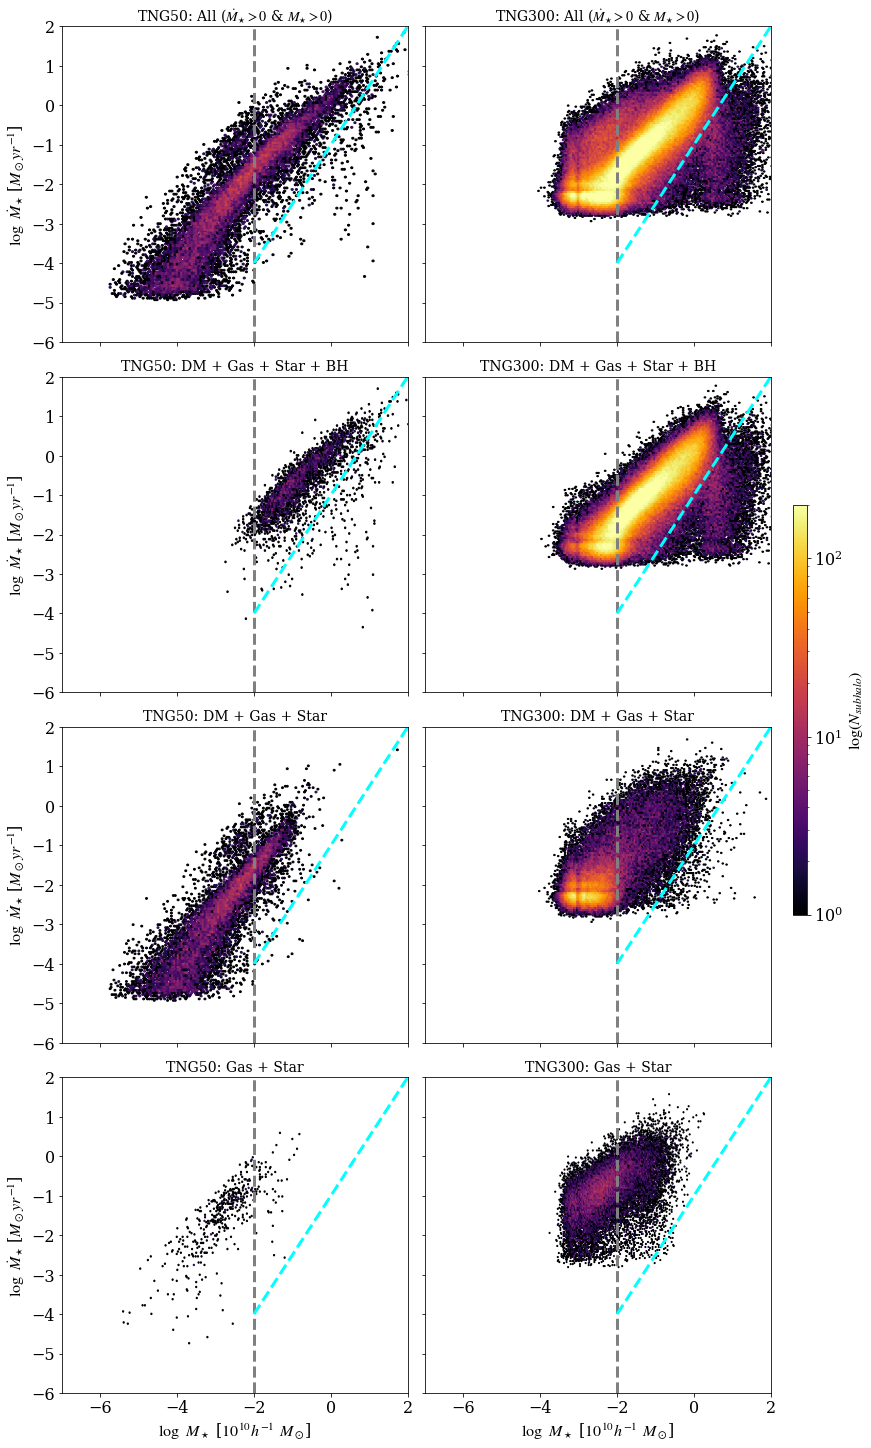

In [50]:
# Create a 2×2 figure
fig, axes = plt.subplots(4, 2, figsize=(12, 20), sharex=True, sharey=True, constrained_layout=True)

# Define datasets and titles for each panel
datasets = [spdf,lpdf,sdgsb, ldgsb,sdgs, ldgs, sgs, lgs]
titles = [r'TNG50: All ($\dot{M}_{\star} > 0$ & $M_{\star} > 0$)', \
          r'TNG300: All ($\dot{M}_{\star} > 0$ & $M_{\star} > 0$)', \
          "TNG50: DM + Gas + Star + BH" , "TNG300: DM + Gas + Star + BH", \
          "TNG50: DM + Gas + Star", "TNG300: DM + Gas + Star", \
          "TNG50: Gas + Star", "TNG300: Gas + Star"]

# Loop through each subplot manually
for ax, data, title in zip(axes.flatten(), datasets, titles):
    # Create hexbin plot
    hb = ax.hexbin(data["log_m_star"], data["log_SubhaloSFR"], gridsize=150, 
                   cmap='inferno', bins='log', mincnt=1, vmin=1, vmax=200)

    # Overplot reference lines
    ax.axvline(x=-2, color='grey', linestyle='--', linewidth=3)
    ax.plot([-2, 2], [-4, 2], color='cyan', linestyle='--', linewidth=3)

    # Set axis limits
    ax.set_xlim(-7, 2)
    ax.set_ylim(-6, 2)

    # Labels and title
    ax.set_title(title, fontsize=14)

# Set common x and y labels (only for bottom-left & left-most panels)
axes[3, 0].set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')
axes[3, 1].set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')
axes[0, 0].set_ylabel(r'$\log$ $\dot{M}_{\star}$ [$M_\odot yr^{-1}$]')
axes[1, 0].set_ylabel(r'$\log$ $\dot{M}_{\star}$ [$M_\odot yr^{-1}$]')
axes[2, 0].set_ylabel(r'$\log$ $\dot{M}_{\star}$ [$M_\odot yr^{-1}$]')
axes[3, 0].set_ylabel(r'$\log$ $\dot{M}_{\star}$ [$M_\odot yr^{-1}$]')

# Add a single colorbar for all panels
cbar = fig.colorbar(hb, ax=axes[:, -1], shrink=0.3, aspect=30, \
                    label=r'$\log(N_{subhalo})$')

# Adjust layout
#plt.tight_layout()

# Save the Figure
plt.savefig("tng-both_4x2_bimodality.pdf", format="pdf", bbox_inches="tight")
plt.savefig("tng-both_4x2_bimodality.png", format="png", bbox_inches="tight")

# Show the plot
plt.show()

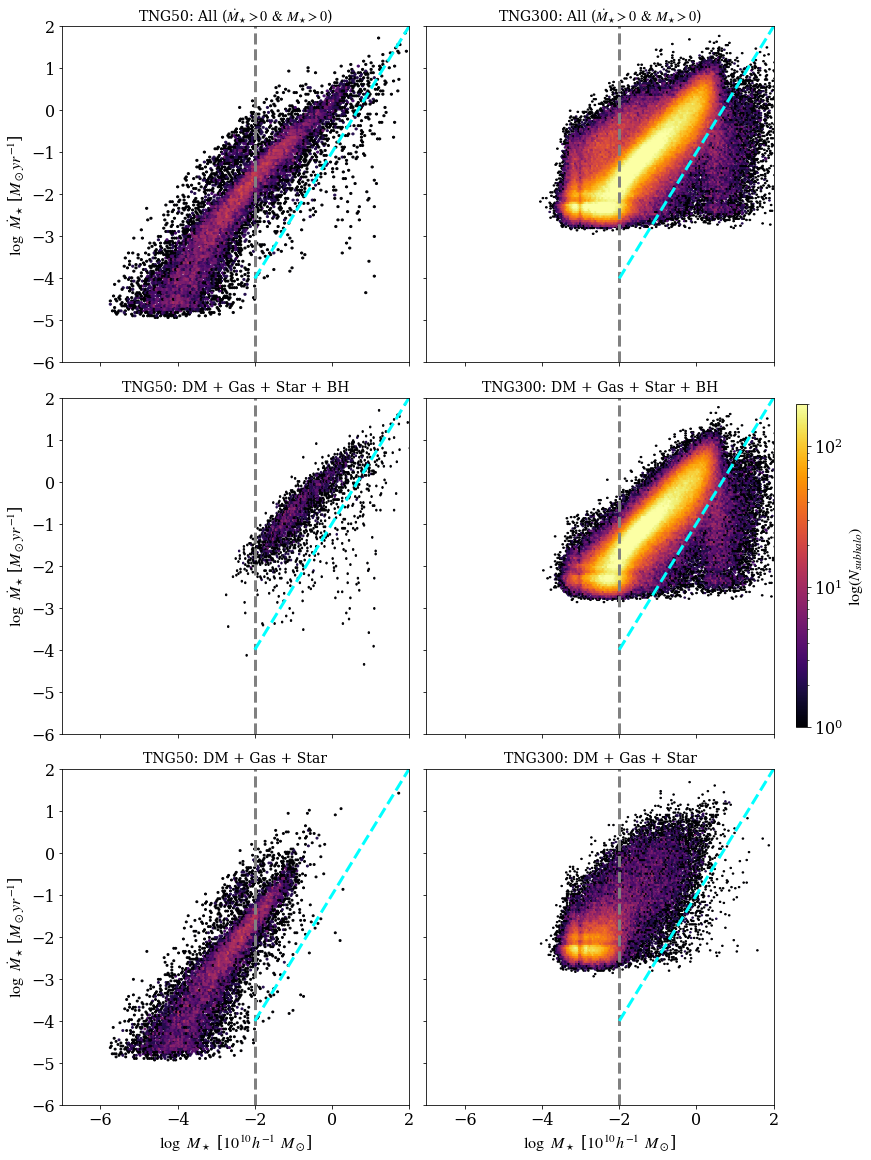

In [51]:
# Create a 2×2 figure
fig, axes = plt.subplots(3, 2, figsize=(12, 16), sharex=True, sharey=True, constrained_layout=True)

# Define datasets and titles for each panel
datasets = [spdf,lpdf,sdgsb, ldgsb,sdgs, ldgs, sgs, lgs]
titles = [r'TNG50: All ($\dot{M}_{\star} > 0$ $&$ $M_{\star} > 0$)', \
          r'TNG300: All ($\dot{M}_{\star} > 0$ $&$ $M_{\star} > 0$)', \
          "TNG50: DM + Gas + Star + BH" , "TNG300: DM + Gas + Star + BH", \
          "TNG50: DM + Gas + Star", "TNG300: DM + Gas + Star"]

# Loop through each subplot manually
for ax, data, title in zip(axes.flatten(), datasets, titles):
    # Create hexbin plot
    hb = ax.hexbin(data["log_m_star"], data["log_SubhaloSFR"], gridsize=150, 
                   cmap='inferno', bins='log', mincnt=1, vmin=1, vmax=200)

    # Overplot reference lines
    ax.axvline(x=-2, color='grey', linestyle='--', linewidth=3)
    ax.plot([-2, 2], [-4, 2], color='cyan', linestyle='--', linewidth=3)

    # Set axis limits
    ax.set_xlim(-7, 2)
    ax.set_ylim(-6, 2)

    # Labels and title
    ax.set_title(title, fontsize=14)

# Set common x and y labels (only for bottom-left & left-most panels)
axes[2, 0].set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')
axes[2, 1].set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')
axes[0, 0].set_ylabel(r'$\log$ $\dot{M}_{\star}$ [$M_\odot yr^{-1}$]')
axes[1, 0].set_ylabel(r'$\log$ $\dot{M}_{\star}$ [$M_\odot yr^{-1}$]')
axes[2, 0].set_ylabel(r'$\log$ $\dot{M}_{\star}$ [$M_\odot yr^{-1}$]')


# Add a single colorbar for all panels
cbar = fig.colorbar(hb, ax=axes[:, -1], shrink=0.3, aspect=30, \
                    label=r'$\log(N_{subhalo})$')

# Adjust layout
#plt.tight_layout()

# Save the Figure
plt.savefig("tng-both_3x2_bimodality.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("tng-both_3x2_bimodality.png", format="png", bbox_inches="tight")

# Show the plot
plt.show()

# UDG Candidates 

### Explode `SubhaloHalfmassRadType`

> c kpc/h: Comoving radius containing half of the mass of this Subhalo split by Type (SubhaloMassType).

In [68]:
# Define the band names
mass_names = ["r_gas", "r_dm", "r_dummy", "r_tr", "r_star", "r_bh"]

In [69]:
# Select and create new columns
for idx, mtype in enumerate(mass_names):
    sdf = sdf.withColumn(mtype, F.col('SubhaloHalfmassRadType').getItem(idx))

In [70]:
# Select and create new columns
for idx, mtype in enumerate(mass_names):
    mdf = mdf.withColumn(mtype, F.col('SubhaloHalfmassRadType').getItem(idx))

In [71]:
# Select and create new columns
for idx, mtype in enumerate(mass_names):
    ldf = ldf.withColumn(mtype, F.col('SubhaloHalfmassRadType').getItem(idx))

In [72]:
%%time
sdf.select(['SubhaloMass',"m_dm", "r_dm", "m_star", "r_star"]).show(5,truncate=False)

+-----------+-----------+---------+------------+---------+
|SubhaloMass|m_dm       |r_dm     |m_star      |r_star   |
+-----------+-----------+---------+------------+---------+
|0.025727784|0.025296362|1.00203  |4.3142235E-4|1.0573597|
|0.02883109 |0.02883109 |1.9209394|0.0         |0.0      |
|0.028777229|0.028769618|1.822356 |7.611349E-6 |0.0      |
|0.02883109 |0.02883109 |3.5629158|0.0         |0.0      |
|0.028800353|0.028800353|3.2584875|0.0         |0.0      |
+-----------+-----------+---------+------------+---------+
only showing top 5 rows

CPU times: user 2.8 ms, sys: 0 ns, total: 2.8 ms
Wall time: 87.2 ms


In [73]:
%%time
mdf.select(['SubhaloMass',"m_dm", "r_dm", "m_star", "r_star"]).show(5,truncate=False)

+-----------+---------+---------+---------+---------+
|SubhaloMass|m_dm     |r_dm     |m_star   |r_star   |
+-----------+---------+---------+---------+---------+
|27477.936  |23325.62 |610.31036|251.01631|47.388058|
|3666.6228  |3184.0862|291.9038 |37.85255 |17.01238 |
|773.4555   |718.18396|82.63892 |42.482437|14.983969|
|339.1331   |310.50958|113.22602|11.620896|6.5302753|
|325.3667   |306.84265|89.24317 |9.032478 |8.990846 |
+-----------+---------+---------+---------+---------+
only showing top 5 rows

CPU times: user 0 ns, sys: 2.22 ms, total: 2.22 ms
Wall time: 142 ms


In [106]:
%%time
# Convert to Pandas and remove rows with zero or negative values
spdf = sdf.select(['m_star', 'r_star', 'SubhaloSFR']).toPandas()
spdf = spdf[(spdf["m_star"] > 0) & (spdf["r_star"] > 0) & (spdf["SubhaloSFR"] > 0)] # Remove zeros & negatives
spdf = spdf.dropna()  # Remove any NaN values
# Convert data to log10 scale
spdf["log_m_star"] = np.log10(spdf["m_star"])
spdf["log_r_star"] = np.log10(spdf["r_star"])
spdf["log_SubhaloSFR"] = np.log10(spdf["SubhaloSFR"])

CPU times: user 108 ms, sys: 28.3 ms, total: 137 ms
Wall time: 7.19 s


In [94]:
%%time
# Convert to Pandas and remove rows with zero or negative values
mpdf = mdf.select(['m_star', 'r_star', 'SubhaloSFR']).toPandas()
mpdf = mpdf[(mpdf["m_star"] > 0) & (mpdf["r_star"] > 0) & (mpdf["SubhaloSFR"] > 0)] # Remove zeros & negatives
mpdf = mpdf.dropna()  # Remove any NaN values
# Convert data to log10 scale
mpdf["log_m_star"] = np.log10(mpdf["m_star"])
mpdf["log_r_star"] = np.log10(mpdf["r_star"])
mpdf["log_SubhaloSFR"] = np.log10(mpdf["SubhaloSFR"])

CPU times: user 75.3 ms, sys: 121 ms, total: 197 ms
Wall time: 16.8 s


In [95]:
%%time
# Convert to Pandas and remove rows with zero or negative values
lpdf = ldf.select(['m_star', 'r_star', 'SubhaloSFR']).toPandas()
lpdf = lpdf[(lpdf["m_star"] > 0) & (lpdf["r_star"] > 0) & (lpdf["SubhaloSFR"] > 0)] # Remove zeros & negatives
lpdf = lpdf.dropna()  # Remove any NaN values
# Convert data to log10 scale
lpdf["log_m_star"] = np.log10(lpdf["m_star"])
lpdf["log_r_star"] = np.log10(lpdf["r_star"])
lpdf["log_SubhaloSFR"] = np.log10(lpdf["SubhaloSFR"])

CPU times: user 180 ms, sys: 273 ms, total: 454 ms
Wall time: 24.7 s


In [96]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

### UDGs Criteria

- $r_{h\star} = \frac{4}{3} R_{e}$ (Hernquist 1990)
- UDGs: $R_{e} > 1.5 kpc$ (Burg et al. 2017) $R_{e} > 1.0 kpc$ ?!?
- $M_{\star}$: $10^{7.5} - 10^{9.0} M_{\odot}$ (Benavides et al. 2023)

In [97]:
tng_hubble_h = 0.6774
cut_udg_reh = np.log10(1.333 * 1.5 * tng_hubble_h) # 1.5 1/h ckpc 
cut_udg_rel = np.log10(1.333 * 1.0 * tng_hubble_h) # 1.0 1/h ckpc 
#print(cut_udg_restar)

In [98]:
udg_len_cut = 1.333 * 1.0 * tng_hubble_h
print(udg_len_cut)

0.9029742


#### Mean Stellar Density at Stellar Half Light Radius 

- Mean Stellar Density at $r_{h\star}$ : $\rho_{h\star} = \frac{\frac{1}{2} M_{\star}}{\frac{4 \pi}{3} r_{h\star}^3}$ 
- UDG Line for the threshold $\rho_{U}$ : 
$\log{r_{h\star}} = \frac{1}{3}\log{M_\star}-\log{\big[ \big( \frac{8\pi \rho_{U}}{3}\big)^{1/3} \big]} = \frac{1}{3}\log{M_\star}-\frac{1}{3}\log{\rho_{U}} - 0.3077$

In [99]:
np.log10(8.0*np.pi/3.0)/3.0

0.30770620165547163

In [133]:
np.log10(8.0*np.pi/3.0)

0.923118604966415

#### What is the fiducial $\rho_{U}$?!?

In [107]:
spdf['rho_star_rh'] = (3.0/(8.0 * np.pi))*spdf.m_star/spdf.r_star**3 
spdf["log_rho_star_rh"] = np.log10(spdf["rho_star_rh"])

In [112]:
mpdf['rho_star_rh'] = (3.0/(8.0 * np.pi))*mpdf.m_star/mpdf.r_star**3 
mpdf["log_rho_star_rh"] = np.log10(mpdf["rho_star_rh"])

In [113]:
lpdf['rho_star_rh'] = (3.0/(8.0 * np.pi))*lpdf.m_star/lpdf.r_star**3 
lpdf["log_rho_star_rh"] = np.log10(lpdf["rho_star_rh"])

In [114]:
spdf.head(3)

m_star     r_star  SubhaloSFR  log_m_star  log_r_star  \
2048  368.292999  29.281168    1.157833    2.566194    1.466588   
2050   13.025371   5.206594    0.000985    1.114790    0.716554   
2056    2.528330   3.253374    3.975659    0.402834    0.512334   

      log_SubhaloSFR  rho_star_rh  log_rho_star_rh  
2048        0.063646     0.001751        -2.756690  
2050       -3.006362     0.011016        -1.957989  
2056        0.599409     0.008764        -2.057287

In [115]:
(3.0/(8.0 * np.pi))*368.292999/29.281168**3 

0.001751094843914501

In [110]:
spdf.columns

Index(['m_star', 'r_star', 'SubhaloSFR', 'log_m_star', 'log_r_star',
       'log_SubhaloSFR', 'rho_star_rh', 'log_rho_star_rh'],
      dtype='object')

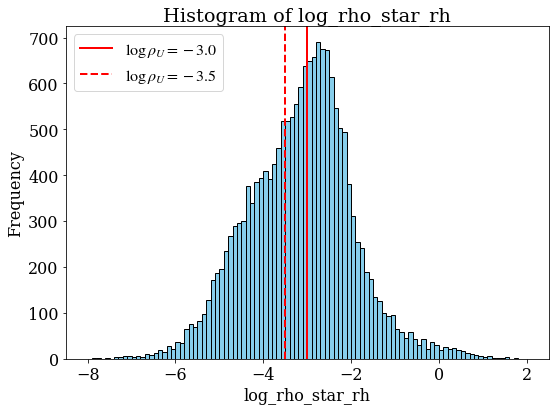

In [170]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(spdf['log_rho_star_rh'], bins=100, range=(-8, 2.0), color='skyblue', edgecolor='black')

plt.axvline(x=-3.0,color='red',linestyle='-',linewidth=2, label=r'$\log \rho_{U} = -3.0$')
plt.axvline(x=-3.5,color='red',linestyle='--',linewidth=2, label=r'$\log \rho_{U} = -3.5$')
# Adding titles and labels
plt.title('Histogram of log_rho_star_rh')
plt.xlabel('log_rho_star_rh')
plt.ylabel('Frequency')

plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

- $\log{\rho_{U}} = \log{M_\star} - 3 \log{r_{h\star}} - 0.9231$

In [135]:
cut_udg_reh, cut_udg_rel

(0.13176660077815192, -0.04432465827752932)

In [144]:
xx = np.arange(101)/100.0 * 20.0 -  10.0 # x = -10 ~ 10 

In [149]:
yh = xx - 3.0 * cut_udg_reh - 0.9231 
yl = xx - 3.0 * cut_udg_rel - 0.9231

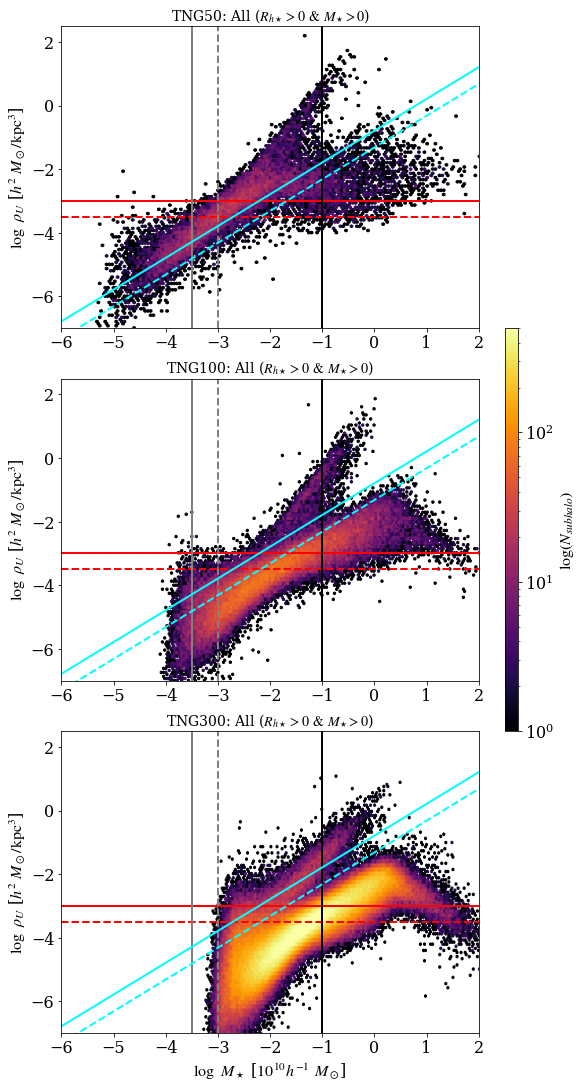

In [162]:
# Create a 3×1 figure
fig, axes = plt.subplots(3, 1, figsize=(8, 15), sharex=True, sharey=True, constrained_layout=True)

# Define datasets and titles for each panel
datasets = [spdf, mpdf, lpdf]
titles = [r'TNG50: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)',
          r'TNG100: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)',
          r'TNG300: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)']

# Loop through each subplot manually
for ax, data, title in zip(axes.flatten(), datasets, titles):
    # Create hexbin plot for log_m_star vs log_rho_star_rh
    hb = ax.hexbin(data["log_m_star"], data["log_rho_star_rh"], gridsize=150,
                   cmap='inferno', bins='log', mincnt=1, vmin=1, vmax=500)

    # Optional: Add reference lines (customize as needed)
    # Example: density thresholds or cut-offs
    # ax.axhline(y=value, ...) if needed
    ax.axhline(y=-3.0,color='red',linestyle='-',linewidth=2)
    ax.axhline(y=-3.5,color='red',linestyle='--',linewidth=2)
    
    ax.axvline(x=-1.0,color='black',linestyle='-',linewidth=2)
    ax.axvline(x=-3.5,color='grey',linestyle='-',linewidth=2)
    ax.axvline(x=-3.0,color='grey',linestyle='--',linewidth=2)
    
    #ax.axvline(x=-1.0,color='grey',linestyle='--',linewidth=2)
    

    # Optional annotation (edit or comment out as needed)
    #ax.text(-3.7, 2.2, 'UDG Zone', fontsize=18, color='blue', ha='right', va='top')
    
    # Overlay the cyan reference lines
    ax.plot(xx, yh, color='cyan', linestyle='--', linewidth=2, label='UDG High')
    ax.plot(xx, yl, color='cyan', linestyle='-', linewidth=2, label='UDG Low')

    # Set axis limits
    ax.set_xlim(-6, 2)
    ax.set_ylim(-7, 2.5)

    # Title
    ax.set_title(title, fontsize=14)
    
    # Ensure x-tick labels are visible on all axes
    ax.tick_params(labelbottom=True)

# Add shared labels
axes[2].set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')
for ax in axes:
    ax.set_ylabel(r'$\log$ $\rho_{U}$ [$h^{2}~M_\odot / {\rm kpc}^3$]')

# Colorbar shared across panels
cbar = fig.colorbar(hb, ax=axes, shrink=0.4, aspect=30,
                    label=r'$\log(N_{subhalo})$')

# Save and show
plt.savefig("tng-all_3x1_rho_star.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("tng-all_3x1_rho_star.png", format="png", bbox_inches="tight")
plt.show()

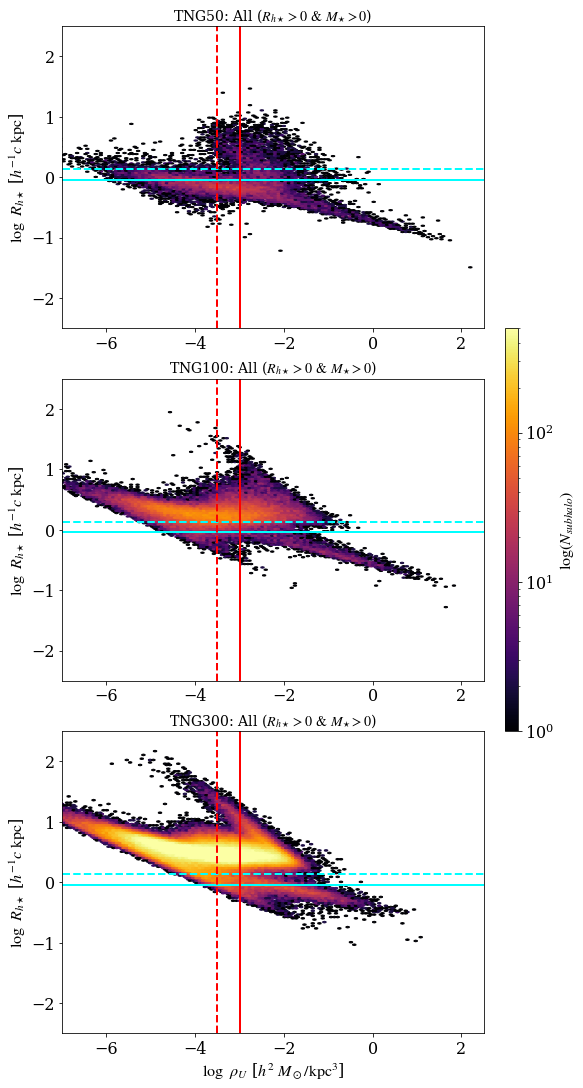

In [181]:
# Create a 3×1 figure
fig, axes = plt.subplots(3, 1, figsize=(8, 15), sharex=True, sharey=True, constrained_layout=True)

# Define datasets and titles
datasets = [spdf, mpdf, lpdf]
titles = [r'TNG50: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)',
          r'TNG100: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)',
          r'TNG300: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)']

# Loop through subplots
for ax, data, title in zip(axes.flatten(), datasets, titles):
    # Create hexbin plot
    hb = ax.hexbin(data["log_rho_star_rh"], data["log_r_star"], gridsize=150,
                   cmap='inferno', bins='log', mincnt=1, vmin=1, vmax=500)

    # Optional: Add any vertical/horizontal cut lines here if relevant
    # Example:
    # ax.axvline(x=value, color='blue', linestyle='--', linewidth=2)

    # UDG zone annotation placeholder (adjust/remove as needed)
    #ax.text(1.0, 2.2, 'UDG Zone', fontsize=18, color='blue', ha='right', va='top')
    
    # Overplot reference lines
    #ax.axvline(x=-3.0, color='grey', alpha=0.5, linestyle='--', linewidth=3)
    ax.plot([-10, 10], [cut_udg_rel, cut_udg_rel], color='cyan', linestyle='-', linewidth=2)
    ax.plot([-10, 10], [cut_udg_reh, cut_udg_reh], color='cyan', linestyle='--', linewidth=2)
    #ax.plot([-1, -1], [cut_udg_rel, 3], color='blue', linestyle='-', linewidth=3)
    
    ax.axvline(x=-3.5,color='red',linestyle='--',linewidth=2)
    ax.axvline(x=-3.0,color='red',linestyle='-',linewidth=2)

    # Axis limits
    ax.set_xlim(-7, 2.5)
    ax.set_ylim(-2.5, 2.5)

    # Title
    ax.set_title(title, fontsize=14)

    # Make sure x-ticks are shown for all panels
    ax.tick_params(labelbottom=True)

    # Set y-axis label
    ax.set_ylabel(r'$\log$ ${R}_{h\star}$ [$h^{-1}c~ {\rm kpc}$]')

# Shared x-label only at the bottom
axes[2].set_xlabel(r'$\log$ $\rho_{U}$ [$h^{2}~M_\odot / {\rm kpc}^3$]')

# Colorbar
cbar = fig.colorbar(hb, ax=axes, shrink=0.4, aspect=30,
                    label=r'$\log(N_{subhalo})$')

# Save and show
plt.savefig("tng-all_3x1_rho_vs_rstar.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("tng-all_3x1_rho_vs_rstar.png", format="png", bbox_inches="tight")
plt.show()

- $\log{r_{h\star}} = \frac{1}{3}\log{M_\star}-\frac{1}{3}\log{\rho_{U}} - 0.3077$

In [182]:
xx = np.arange(101)/100.0 * 20.0 -  10.0 # x = -10 ~ 10 

In [185]:
yh = xx/3.0 - 0.3077 + 3.5/3.0
yl = xx/3.0 - 0.3077 + 3.0/3.0

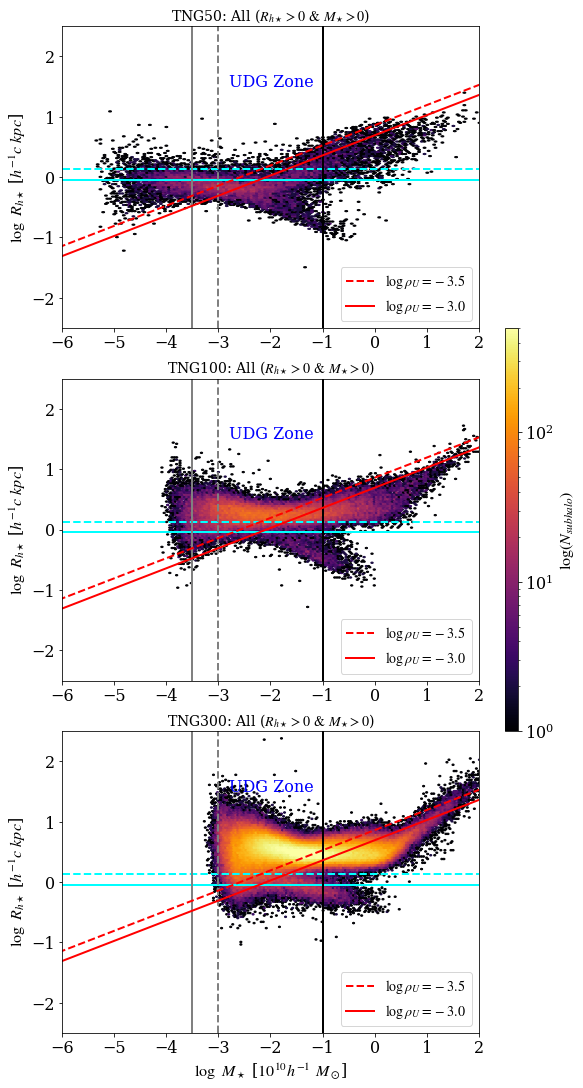

In [196]:
# Create a 2×1 figure
fig, axes = plt.subplots(3, 1, figsize=(8, 15), sharex=True, sharey=True, constrained_layout=True)

# Define datasets and titles for each panel
datasets = [spdf,mpdf,lpdf]
titles = [r'TNG50: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)', \
          r'TNG100: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)', \
          r'TNG300: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)']

# Loop through each subplot manually
for ax, data, title in zip(axes.flatten(), datasets, titles):
    # Create hexbin plot
    hb = ax.hexbin(data["log_m_star"], data["log_r_star"], gridsize=150, 
                   cmap='inferno', bins='log', mincnt=1, vmin=1, vmax=500)

    # Overplot reference lines
    #ax.axvline(x=-3.0, color='grey', alpha=0.5, linestyle='--', linewidth=3)
    ax.plot([-10, 10], [cut_udg_rel, cut_udg_rel], color='cyan', linestyle='-', linewidth=2)
    ax.plot([-10, 10], [cut_udg_reh, cut_udg_reh], color='cyan', linestyle='--', linewidth=2)
    #ax.plot([-1, -1], [cut_udg_rel, 3], color='cyan', linestyle='-', linewidth=3)
    
    ax.axvline(x=-3.0, color='grey', alpha=1.0, linestyle='--', linewidth=2)
    ax.axvline(x=-3.5, color='grey', alpha=1.0, linestyle='-', linewidth=2)
    ax.axvline(x=-1.0, color='black', alpha=1.0, linestyle='-', linewidth=2)
    
    # Text annotation
    ax.text(-2.8, 1.5, 'UDG Zone', fontsize=16,alpha=1.0, color='blue')
    
    # Overlay the cyan reference lines
    ax.plot(xx, yh, color='red', linestyle='--', linewidth=2,label=r'$\log \rho_{U} = -3.5$')
    ax.plot(xx, yl, color='red', linestyle='-', linewidth=2, label=r'$\log \rho_{U} = -3.0$')

    ax.legend(loc='lower right',fontsize=14)

    # Set axis limits
    ax.set_xlim(-6, 2)
    ax.set_ylim(-2.5, 2.5)

    # Labels and title
    ax.set_title(title, fontsize=14)

# Set common x and y labels (only for bottom-left & left-most panels)
#axes[1, 0].set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')

#axes[0].axvline(x=-3.0, color='grey', alpha=0.5, linestyle='--', linewidth=2)
#axes[1].axvline(x=-2.0, color='grey', alpha=0.5, linestyle='--', linewidth=3)
#axes[2].axvline(x=-1.5, color='grey', alpha=0.5, linestyle='--', linewidth=3)
#axes[1].axvline(x=-3.0, color='grey', alpha=0.5, linestyle='--', linewidth=3)
#axes[2].axvline(x=-3.0, color='grey', alpha=0.5, linestyle='--', linewidth=3)

# Set axis labels
axes[0].set_ylabel(r'$\log$ ${R}_{h\star}$ [$h^{-1}c~ kpc$]')
axes[1].set_ylabel(r'$\log$ ${R}_{h\star}$ [$h^{-1}c~ kpc$]')
axes[2].set_ylabel(r'$\log$ ${R}_{h\star}$ [$h^{-1}c~ kpc$]')
axes[2].set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')

# Ensure tick values are shown even without x-axis labels
for ax in axes:
    ax.tick_params(labelbottom=True)

# Add a single colorbar for all panels
cbar = fig.colorbar(hb, ax=axes, shrink=0.4, aspect=30, \
                    label=r'$\log(N_{subhalo})$')

# Adjust layout
#plt.tight_layout()

# Save the Figure
plt.savefig("tng-all_3x1_r_star.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("tng-all_3x1_r_star.png", format="png", bbox_inches="tight")

# Show the plot
plt.show()

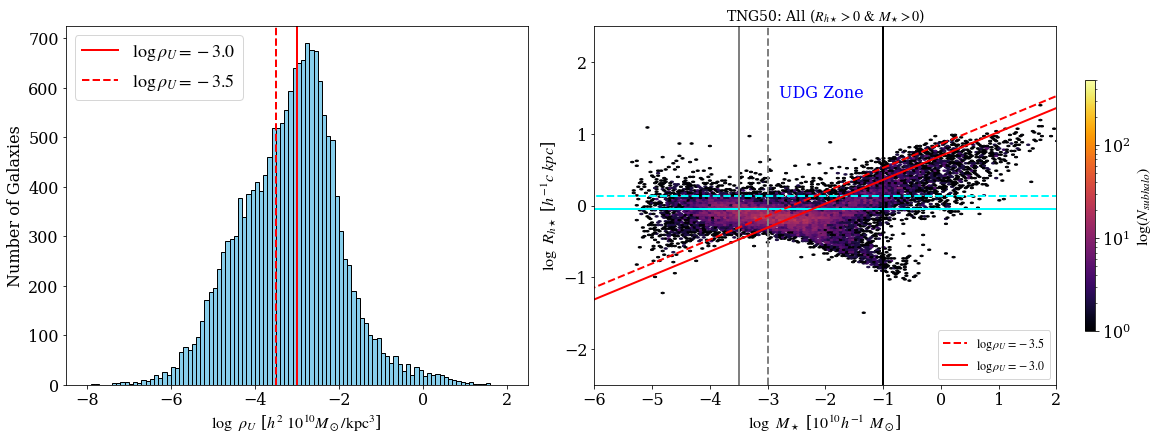

In [203]:
import matplotlib.pyplot as plt

# 1 row × 2 column figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# === [Left panel] Histogram ===
ax1 = axes[0]
ax1.hist(spdf['log_rho_star_rh'], bins=100, range=(-8, 2.0), 
         color='skyblue', edgecolor='black')

ax1.axvline(x=-3.0, color='red', linestyle='-', linewidth=2, label=r'$\log \rho_{U} = -3.0$')
ax1.axvline(x=-3.5, color='red', linestyle='--', linewidth=2, label=r'$\log \rho_{U} = -3.5$')

#ax1.set_title('Histogram of log_rho_star_rh', fontsize=14)
ax1.set_xlabel(r'$\log$ $\rho_{U}$ [$h^{2}~10^{10}M_\odot / {\rm kpc}^3$]')
ax1.set_ylabel('Number of Galaxies')
ax1.legend(loc='upper left', fontsize=18)


# === [Right panel] Hexbin Plot ===
ax2 = axes[1]
data = spdf
title = r'TNG50: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)'

hb = ax2.hexbin(data["log_m_star"], data["log_r_star"], gridsize=150, 
                cmap='inferno', bins='log', mincnt=1, vmin=1, vmax=500)

# Reference lines
ax2.plot([-10, 10], [cut_udg_rel, cut_udg_rel], color='cyan', linestyle='-', linewidth=2)
ax2.plot([-10, 10], [cut_udg_reh, cut_udg_reh], color='cyan', linestyle='--', linewidth=2)

ax2.axvline(x=-3.0, color='grey', alpha=1.0, linestyle='--', linewidth=2)
ax2.axvline(x=-3.5, color='grey', alpha=1.0, linestyle='-', linewidth=2)
ax2.axvline(x=-1.0, color='black', alpha=1.0, linestyle='-', linewidth=2)

# UDG 텍스트
ax2.text(-2.8, 1.5, 'UDG Zone', fontsize=16, alpha=1.0, color='blue')

# 붉은 기준선
ax2.plot(xx, yh, color='red', linestyle='--', linewidth=2, label=r'$\log \rho_{U} = -3.5$')
ax2.plot(xx, yl, color='red', linestyle='-', linewidth=2, label=r'$\log \rho_{U} = -3.0$')
ax2.legend(loc='lower right', fontsize=12)

ax2.set_xlim(-6, 2)
ax2.set_ylim(-2.5, 2.5)
ax2.set_title(title, fontsize=14)
ax2.set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')
ax2.set_ylabel(r'$\log$ ${R}_{h\star}$ [$h^{-1}c~ kpc$]')

# Colorbar for hexbin
cbar = fig.colorbar(hb, ax=ax2, shrink=0.7, aspect=25, 
                    label=r'$\log(N_{subhalo})$')

# Save and display
plt.savefig("tng50_hist_left_hexbin_right.pdf", format="pdf", bbox_inches="tight")
plt.show()


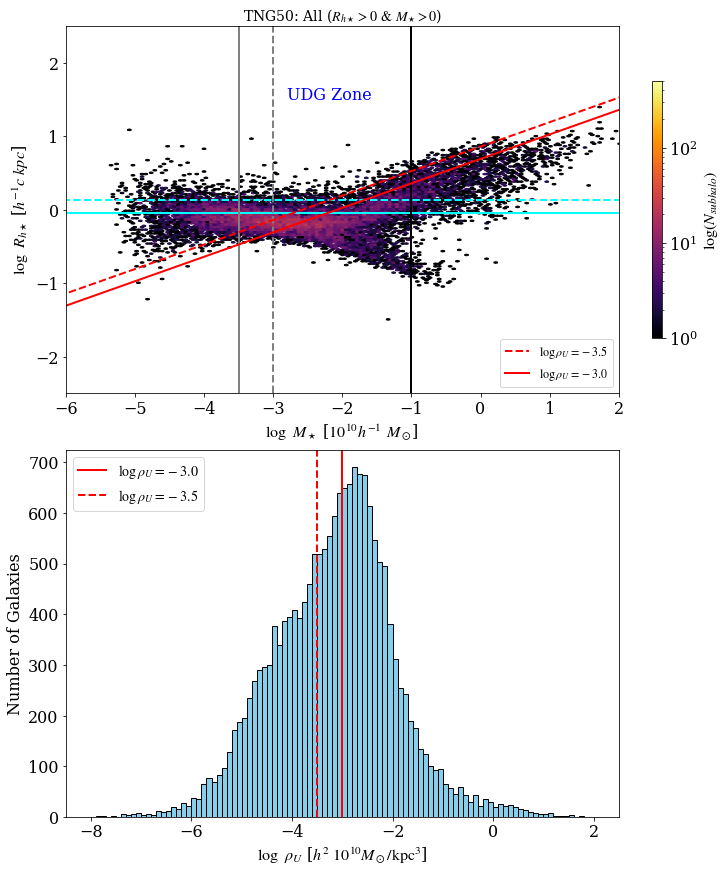

In [205]:
import matplotlib.pyplot as plt

# 2 row × 1 column figure (hexbin 위, 히스토그램 아래)
fig, axes = plt.subplots(2, 1, figsize=(10, 12), constrained_layout=True)

# === [Top panel] Hexbin Plot ===
ax1 = axes[0]
data = spdf
title = r'TNG50: All (${R}_{h\star} > 0$ $&$ $M_{\star} > 0$)'

hb = ax1.hexbin(data["log_m_star"], data["log_r_star"], gridsize=150, 
                cmap='inferno', bins='log', mincnt=1, vmin=1, vmax=500)

# Reference lines
ax1.plot([-10, 10], [cut_udg_rel, cut_udg_rel], color='cyan', linestyle='-', linewidth=2)
ax1.plot([-10, 10], [cut_udg_reh, cut_udg_reh], color='cyan', linestyle='--', linewidth=2)

ax1.axvline(x=-3.0, color='grey', alpha=1.0, linestyle='--', linewidth=2)
ax1.axvline(x=-3.5, color='grey', alpha=1.0, linestyle='-', linewidth=2)
ax1.axvline(x=-1.0, color='black', alpha=1.0, linestyle='-', linewidth=2)

# UDG 텍스트
ax1.text(-2.8, 1.5, 'UDG Zone', fontsize=16, alpha=1.0, color='blue')

# 붉은 기준선
ax1.plot(xx, yh, color='red', linestyle='--', linewidth=2, label=r'$\log \rho_{U} = -3.5$')
ax1.plot(xx, yl, color='red', linestyle='-', linewidth=2, label=r'$\log \rho_{U} = -3.0$')
ax1.legend(loc='lower right', fontsize=12)

ax1.set_xlim(-6, 2)
ax1.set_ylim(-2.5, 2.5)
ax1.set_title(title, fontsize=14)
ax1.set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')
ax1.set_ylabel(r'$\log$ ${R}_{h\star}$ [$h^{-1}c~ kpc$]')

# Colorbar for hexbin
cbar = fig.colorbar(hb, ax=ax1, shrink=0.7, aspect=25,
                    label=r'$\log(N_{subhalo})$')


# === [Bottom panel] Histogram ===
ax2 = axes[1]
ax2.hist(spdf['log_rho_star_rh'], bins=100, range=(-8, 2.0), 
         color='skyblue', edgecolor='black')

ax2.axvline(x=-3.0, color='red', linestyle='-', linewidth=2, label=r'$\log \rho_{U} = -3.0$')
ax2.axvline(x=-3.5, color='red', linestyle='--', linewidth=2, label=r'$\log \rho_{U} = -3.5$')

ax2.set_xlabel(r'$\log$ $\rho_{U}$ [$h^{2}~10^{10}M_\odot / {\rm kpc}^3$]')
ax2.set_ylabel('Number of Galaxies')
ax2.legend(loc='upper left', fontsize=14)

# Save and display
plt.savefig("tng50_hexbin_top_hist_bottom.pdf", format="pdf", bbox_inches="tight")
plt.show()

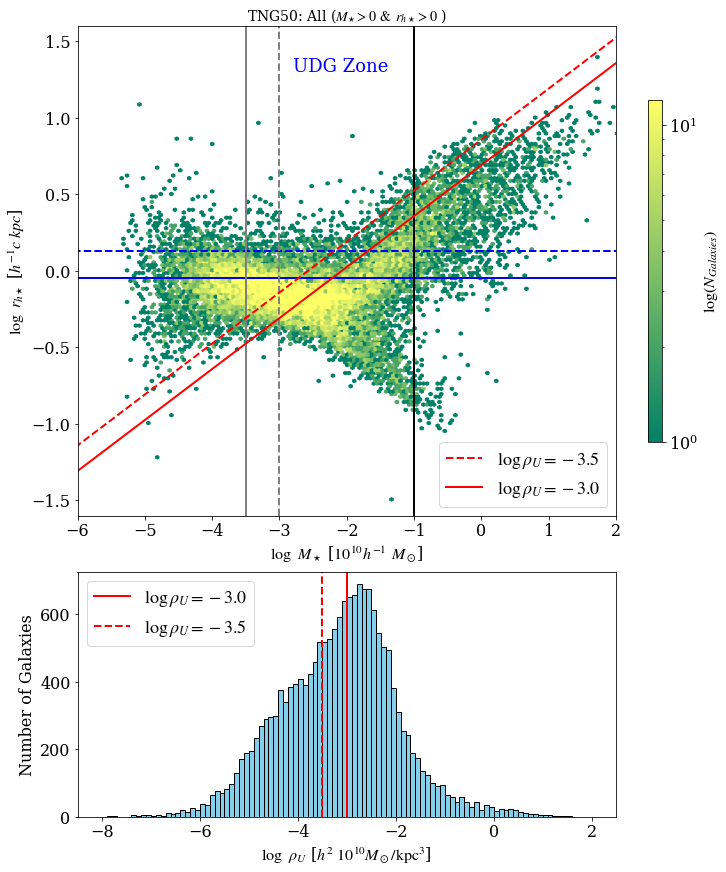

In [256]:
import matplotlib.pyplot as plt

# figure + customized subplot heights using 'gridspec_kw'
fig, axes = plt.subplots(2, 1, figsize=(10, 12), 
                         gridspec_kw={'height_ratios': [2, 1]}, 
                         constrained_layout=True)

# === [Top: Hexbin] ===
ax1 = axes[0]
data = spdf
title = r'TNG50: All ($M_{\star} > 0$ $&$ ${r}_{h\star} > 0$ )'

hb = ax1.hexbin(data["log_m_star"], data["log_r_star"], gridsize=150, 
                cmap='summer', bins='log', mincnt=1, vmin=1, vmax=12)

# Reference lines
ax1.plot([-10, 10], [cut_udg_rel, cut_udg_rel], color='blue', linestyle='-', linewidth=2)
ax1.plot([-10, 10], [cut_udg_reh, cut_udg_reh], color='blue', linestyle='--', linewidth=2)

ax1.axvline(x=-3.0, color='grey', alpha=1.0, linestyle='--', linewidth=2)
ax1.axvline(x=-3.5, color='grey', alpha=1.0, linestyle='-', linewidth=2)
ax1.axvline(x=-1.0, color='black', alpha=1.0, linestyle='-', linewidth=2)

ax1.text(-2.8, 1.3, 'UDG Zone', fontsize=18, alpha=1.0, color='blue')

ax1.plot(xx, yh, color='red', linestyle='--', linewidth=2, label=r'$\log \rho_{U} = -3.5$')
ax1.plot(xx, yl, color='red', linestyle='-', linewidth=2, label=r'$\log \rho_{U} = -3.0$')
ax1.legend(loc='lower right', fontsize=18)

ax1.set_xlim(-6, 2)
ax1.set_ylim(-1.6, 1.6)
ax1.set_title(title, fontsize=14)
ax1.set_xlabel(r'$\log$ $M_\star$ [$10^{10} h^{-1}$ $M_\odot $]')
ax1.set_ylabel(r'$\log$ ${r}_{h\star}$ [$h^{-1}c~ kpc$]')

cbar = fig.colorbar(hb, ax=ax1, shrink=0.7, aspect=25,
                    label=r'$\log(N_{Galaxies})$')


# === [Bottom: Histogram] ===
ax2 = axes[1]
ax2.hist(spdf['log_rho_star_rh'], bins=100, range=(-8, 2.0), 
         color='skyblue', edgecolor='black')

ax2.axvline(x=-3.0, color='red', linestyle='-', linewidth=2, label=r'$\log \rho_{U} = -3.0$')
ax2.axvline(x=-3.5, color='red', linestyle='--', linewidth=2, label=r'$\log \rho_{U} = -3.5$')

ax2.set_xlabel(r'$\log$ $\rho_{U}$ [$h^{2}~10^{10}M_\odot / {\rm kpc}^3$]')
ax2.set_ylabel('Number of Galaxies')
ax2.legend(loc='upper left', fontsize=18)

# Save and display
plt.savefig("UDG_criteria_tng50_hexbin_histo.pdf", format="pdf", bbox_inches="tight")
plt.show()

### UDGs Criteria

- $r_{h\star} = \frac{4}{3} R_{e}$ (Hernquist 1990)
- UDGs: $R_{e} > 1.5 kpc$ (Burg et al. 2017) $R_{e} > 1.0 kpc$ ?!?
- $M_{\star}$: $10^{7.5} - 10^{9.0} M_{\odot}$ (Benavides et al. 2023)

#### Mean Stellar Density at Stellar Half Light Radius 

- Mean Stellar Density at $r_{h\star}$ : $\rho_{h\star} = \frac{\frac{1}{2} M_{\star}}{\frac{4 \pi}{3} r_{h\star}^3}$, unit [$h^{2}~10^{10}M_\odot / {\rm kpc}^3$]
- UDG Line for the threshold $\rho_{U}$ : 
$\log{r_{h\star}} = \frac{1}{3}\log{M_\star}-\log{\big[ \big( \frac{8\pi \rho_{U}}{3}\big)^{1/3} \big]} = \frac{1}{3}\log{M_\star}-\frac{1}{3}\log{\rho_{U}} - 0.3077$

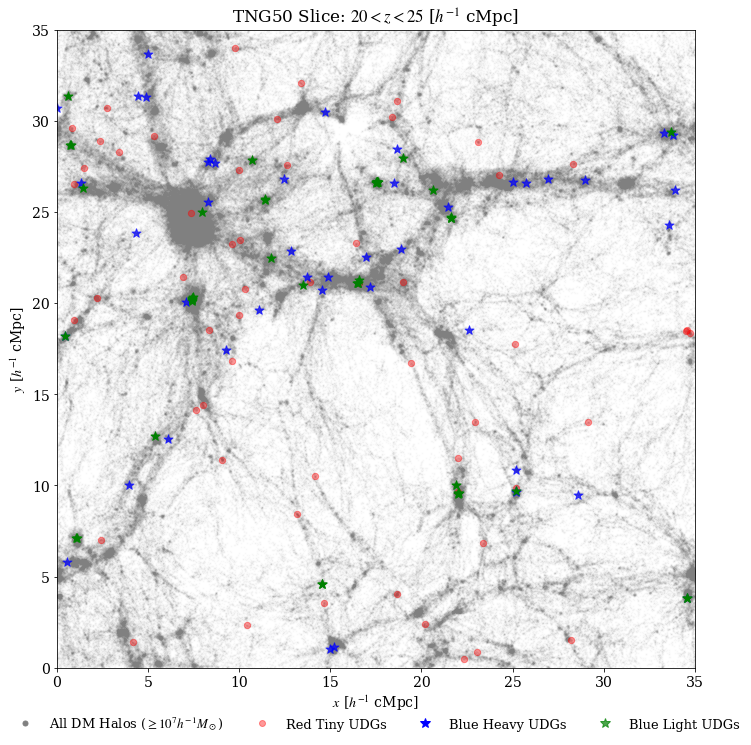

In [334]:
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Plot settings
plt.rc('font', family='serif') 
plt.rcParams.update({'font.size': 14})
plt.rcParams['mathtext.fontset'] = 'stix'

# Filter the data
locpdf_slice = sdmpdf[(sdmpdf['cz'] > 20000) & (sdmpdf['cz'] < 25000)]
rtudgpdf_slice = rtudgpdf[(rtudgpdf['cz'] > 20000) & (rtudgpdf['cz'] < 25000)]
bhudgpdf_slice = bhudgpdf[(bhudgpdf['cz'] > 20000) & (bhudgpdf['cz'] < 25000)]
bludgpdf_slice = bludgpdf[(bludgpdf['cz'] > 20000) & (bludgpdf['cz'] < 25000)]

# Create figure
plt.figure(figsize=(11, 11.8))

# Plot with actual scatter marker sizes
plt.scatter(locpdf_slice['cx'], locpdf_slice['cy'], 
            color='grey', alpha=0.03, s=1)
plt.scatter(rtudgpdf_slice['cx'], rtudgpdf_slice['cy'], 
            color='red', alpha=0.4, s=40)
plt.scatter(bhudgpdf_slice['cx'], bhudgpdf_slice['cy'], 
            color='blue', alpha=0.7, s=90, marker='*')
plt.scatter(bludgpdf_slice['cx'], bludgpdf_slice['cy'], 
            color='green', alpha=1.0, s=90, marker='*')

# Axis labels and title
plt.xlabel(r'$x$ [$h^{-1}$ cMpc]')
plt.ylabel(r'$y$ [$h^{-1}$ cMpc]')
plt.title('TNG50 Slice: $20 < z < 25$ [$h^{-1}$ cMpc]')

# Custom legend handles (larger than actual scatter)
custom_legend = [
    Line2D([0], [0], marker='o', color='grey', linestyle='None', markersize=5,
           label=r'All DM Halos ($\geq 10^{7} h^{-1} M_\odot$)'),
    Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=6,alpha=0.4, label='Red Tiny UDGs'),
    Line2D([0], [0], marker='*', color='blue', linestyle='None', markersize=10,alpha=1.0, label='Blue Heavy UDGs'),
    Line2D([0], [0], marker='*', color='green', linestyle='None', markersize=10,alpha=0.7, label='Blue Light UDGs')
]

# Bottom horizontal legend
plt.legend(handles=custom_legend,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.12),  # reduced distance to x-axis
           fontsize=13,
           ncol=4,
           frameon=False)

# Format ticks: show in Mpc instead of kpc
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y/1000:.0f}"))

plt.xlim(0, 35000)
plt.ylim(0, 35000)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.subplots_adjust(bottom=0.22)

# Save the figure
plt.savefig("tng-50-udg-loc-dm-v2.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("tng-50-udg-loc-dm-v2.png", format="png", bbox_inches="tight", facecolor='white')

# Show plot
plt.show()

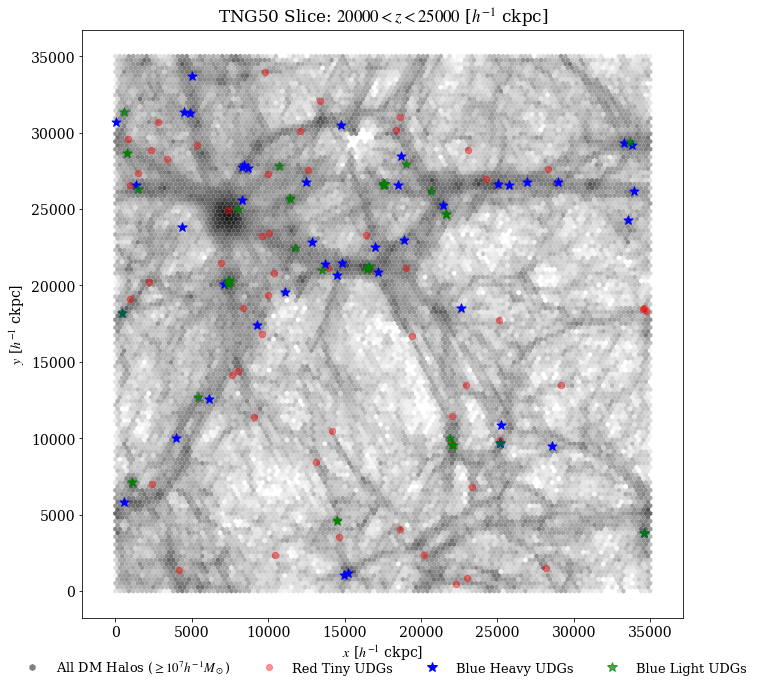

In [336]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# Filter the data for the slice 0 < cz < 50
locpdf_slice = sdmpdf[(sdmpdf['cz'] > 20000) & (sdmpdf['cz'] < 25000)]
rtudgpdf_slice = rtudgpdf[(rtudgpdf['cz'] > 20000) & (rtudgpdf['cz'] < 25000)]
bhudgpdf_slice = bhudgpdf[(bhudgpdf['cz'] > 20000) & (bhudgpdf['cz'] < 25000)]
bludgpdf_slice = bludgpdf[(bludgpdf['cz'] > 20000) & (bludgpdf['cz'] < 25000)]

# Create a figure
plt.figure(figsize=(12, 9.7))

# Plot locpdf: grey, low alpha
#plt.scatter(locpdf_slice['cx'], locpdf_slice['cy'], 
#            color='grey', alpha=0.03, s=1, label=r'All DM Halos ($\geq 10^{7} h^{-1} M_\odot$)')

plt.hexbin(locpdf_slice['cx'], locpdf_slice['cy'], 
           gridsize=120, cmap='Greys', bins='log', alpha=0.9, \
           linewidth=0,label=r'All DM Halos ($\geq 10^{7} h^{-1} M_\odot$)')

# Plot udgpdf: blue, high alpha
plt.scatter(rtudgpdf_slice['cx'], rtudgpdf_slice['cy'], 
            color='red', alpha=0.4, s=40, label='Red Dead UDGs')

# Plot udgpdf: blue, high alpha
plt.scatter(bhudgpdf_slice['cx'], bhudgpdf_slice['cy'], 
            color='blue', alpha=1.0, s=90, marker='*', label='Blue Heavy UDGs')

# Plot udgpdf: blue, high alpha
plt.scatter(bludgpdf_slice['cx'], bludgpdf_slice['cy'], 
            color='green', alpha=0.7, s=90, marker='*', label='Blue Light UDGs')



# Labeling
plt.xlabel(r'$x$ [$h^{-1}$ ckpc]')
plt.ylabel(r'$y$ [$h^{-1}$ ckpc]')
plt.title('TNG50 Slice: $20000 < z < 25000$ [$h^{-1}$ ckpc]')

# Add legend outside
#plt.legend(loc='upper left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.,fontsize=12)

custom_legend = [
    Line2D([0], [0], marker='h', color='grey', linestyle='None', markersize=6, label=r'All DM Halos ($\geq 10^{7} h^{-1} M_\odot$)'),
    Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=6,alpha=0.4, label='Red Tiny UDGs'),
    Line2D([0], [0], marker='*', color='blue', linestyle='None', markersize=10,alpha=1.0, label='Blue Heavy UDGs'),
    Line2D([0], [0], marker='*', color='green', linestyle='None', markersize=10,alpha=0.7, label='Blue Light UDGs')
]

#custom_legend = [
#    Patch(facecolor='grey', edgecolor='none', label=r'All DM Halos ($\geq 10^{7} h^{-1} M_\odot$)'),
#    Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=6, label='Red Dead UDGs'),
#    Line2D([0], [0], marker='*', color='blue', linestyle='None', markersize=10, label='Blue Heavy UDGs'),
#    Line2D([0], [0], marker='*', color='green', linestyle='None', markersize=10, label='Blue Light UDGs')
#]

# Legend outside
#plt.legend(handles=custom_legend, loc='upper left', bbox_to_anchor=(1.00, 1.0), fontsize=13)

# Bottom horizontal legend
plt.legend(handles=custom_legend,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.12),  # reduced distance to x-axis
           fontsize=13,
           ncol=4,
           frameon=False)


# Aspect ratio and limits (optional)
plt.axis('equal')
# plt.xlim(...)  # You can set limits if needed
# plt.ylim(...)

plt.tight_layout()
plt.subplots_adjust(right=0.8)

# Save the Figure
plt.savefig("tng-50-udg-loc-dm-v3.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("tng-50-udg-loc-dm-v3.png", format="png", bbox_inches="tight",facecolor='white')

plt.show()

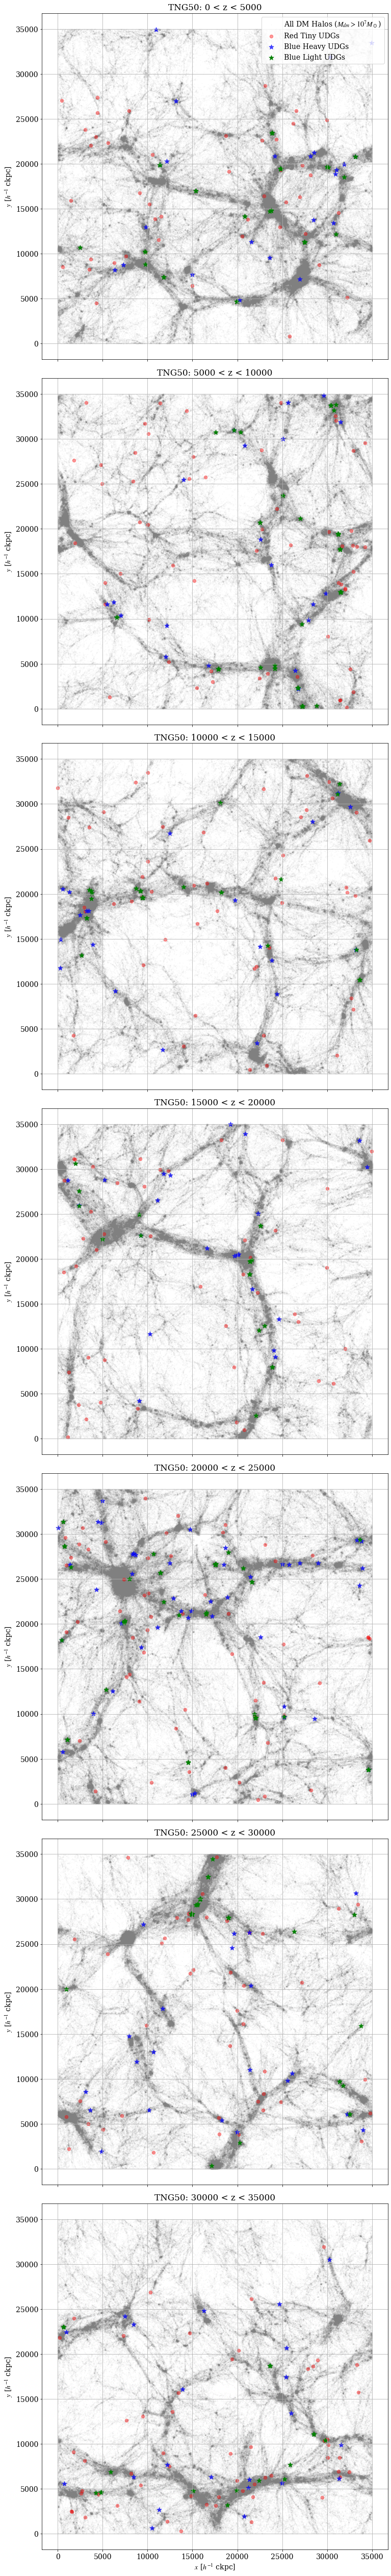

In [338]:
cz_slices = [
    (0, 5000),
    (5000, 10000),
    (10000, 15000),
    (15000, 20000),
    (20000, 25000),
    (25000, 30000),
    (30000, 35000)
]

# Use constrained_layout instead of tight_layout
fig, axes = plt.subplots(7, 1, figsize=(17, 70), sharex=True, constrained_layout=True)

for i, (cz_min, cz_max) in enumerate(cz_slices):
    ax = axes[i]
    show_legend = (i == 0)  # Only show legend in the first panel

    loc_slice = sdmpdf[(sdmpdf['cz'] > cz_min) & (sdmpdf['cz'] < cz_max)]
    rd_slice = rtudgpdf[(rtudgpdf['cz'] > cz_min) & (rtudgpdf['cz'] < cz_max)]
    bh_slice = bhudgpdf[(bhudgpdf['cz'] > cz_min) & (bhudgpdf['cz'] < cz_max)]
    bl_slice = bludgpdf[(bludgpdf['cz'] > cz_min) & (bludgpdf['cz'] < cz_max)]

    ax.scatter(loc_slice['cx'], loc_slice['cy'], color='grey', alpha=0.03, s=1, \
               label=r'All DM Halos ($M_{dm} > 10^{7} M_\odot$)')
    ax.scatter(rd_slice['cx'], rd_slice['cy'], color='red', alpha=0.4, s=40, label='Red Tiny UDGs')
    ax.scatter(bh_slice['cx'], bh_slice['cy'], color='blue', alpha=0.7, s=90, marker='*', label='Blue Heavy UDGs')
    ax.scatter(bl_slice['cx'], bl_slice['cy'], color='green', alpha=1.0, s=90, marker='*', label='Blue Light UDGs')

    ax.set_ylabel(r'$y$ [$h^{-1}$ ckpc]')
    ax.set_title(f'TNG50: {cz_min} < z < {cz_max}')
    ax.set_aspect('equal', adjustable='box')
    
    if show_legend:
        ax.legend(loc='upper right', fontsize=14)
    ax.grid(True)

axes[-1].set_xlabel(r'$x$ [$h^{-1}$ ckpc]')

# Save and show
plt.savefig("tng-50-udg-loc-7panels-dm.pdf", format="pdf", bbox_inches="tight")
plt.show()